# Evaluation Test: QMLHEP 2023 Google Summer of Code (GSoC) Machine Learning for Science (ML4Sci) Tasks

Author: Roy T. Forestano

Date: 3 April 2023

# Task I: Quantum Computing Part

Author: Roy T. Forestano

Date: 3 April 2023


1) Implement a simple quantum operation with Cirq or Pennylane:

1. (a) With 5 qubits 
2. (b) Apply Hadamard operation on every qubit 
3. (c) Apply CNOT operation on (0, 1), (1,2), (2,3), (3,4) 
4. (d) SWAP (0, 4) 
5. (e) Rotate X with pi/2 on any qubit 
6. (f) Plot the circuit 


2) Implement a second circuit with a framework of your choice:

1. (a) Apply a Hadmard gate to the first qubit
2. (b) rotate the second qubit by pi/3 around X
3. (c) Apply Hadamard gate to the third and fourth qubit
4. (d) Perform a swap test between the states of the first and second qubit $\vert q_1 q_2 \rangle$ and the third and fourth qubit $\vert q_3 q_4 \rangle$

Note: we must add a return function, such as the expectation value of a chosen operator, to see the results. Here, we will use the Pauli operators acting on the final state of one qubit to demonstrate.

## Import Packages and Device

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

## Exercise 1: Using Pennylane

In [3]:
n=5 # (a) number of wires (or qubits)
dev1 = qml.device("default.qubit", wires=n) 

## Construct the QNode

Convert the quantum function into a QNode running on device dev1 by applying the qnode() decorator.

In [4]:
@qml.qnode(dev1)
def circuit(params):
    for i in range(n): # (b) Hadamard operation on every qubit
        qml.Hadamard(wires=i)
    for i in range(n-1):  # (c) CNOT operation on (0, 1), (1,2), (2,3), (3,4) 
        qml.CNOT(wires=[i,i+1])
    qml.SWAP(wires=[0,4])   # (d) SWAP (0, 4) 
    qml.RX(params[0], wires=3)  # (e) Rotate X with pi/2 on any qubit 
    return qml.expval(qml.PauliX(3))

## Visualize Output and Circuit

In [5]:
params = [np.pi/2]
print(circuit(params))

0.9999999999999991


In [6]:
# (f) Plot the circuit
print(qml.draw(circuit)(params))
#dev1._circuit.draw(output="mpl")

0: ──H─╭●──────────╭SWAP───────────┤     
1: ──H─╰X─╭●───────│───────────────┤     
2: ──H────╰X─╭●────│───────────────┤     
3: ──H───────╰X─╭●─│──────RX(1.57)─┤  <X>
4: ──H──────────╰X─╰SWAP───────────┤     


---
## Exercise 2: Using Pennylane

In [7]:
n2=4 # number of wires (or qubits)
dev2 = qml.device("default.qubit", wires=n2) 

@qml.qnode(dev2)
def circuit2(params):
    qml.Hadamard(wires=0) # (a) Hadmard gate to the first qubit
    qml.RX(params[0], wires=1) # (b) rotate the second qubit by pi/3 around X
    for i in range(n2-2,n2,1):  # (c) Hadamard gate to the third and fourth qubit 
        qml.Hadamard(wires=i)
    for i in range(0,2):
        qml.SWAP(wires=[i,i+2])   # (d) swap test between the states of the first and second qubit $\vert q_1 q_2 \rangle$ and the third and fourth qubit $\vert q_3 q_4 \rangle$
    return qml.expval(qml.PauliZ(3))

In [8]:
# Evaluate circuit
params2 = [np.pi/3]
print(circuit2(params2))

0.4999999999999998


In [9]:
# Plot the circuit
print(qml.draw(circuit2)(params2))

0: ──H────────╭SWAP───────┤     
1: ──RX(1.05)─│─────╭SWAP─┤     
2: ──H────────╰SWAP─│─────┤     
3: ──H──────────────╰SWAP─┤  <Z>


---

# Task II:  Classical Graph Neural Networks (GNN) 

Classifying Pythia8 Quark and Gluon Jets Using a Graph Convolutional Network (GCN) and Graph Convolutional Attention Network (GCAT)

Author: Roy T. Forestano

Date: 3 April 2023

$\bf\text{Database Information: Pythia8 Quark and Gluon Jets for Energy Flow}$

Two datasets of quark and gluon jets generated with Pythia 8, one with all kinematically realizable quark jets and one that excludes charm and bottom quark jets (at the level of the hard process). The one without c and b jets was originally used in Energy Flow Networks: Deep Sets for Particle Jets. Generation parameters are listed below:

Pythia 8.226 (without bc jets), Pythia 8.235 (with bc jets), s√=14TeV
Quarks from WeakBosonAndParton:qg2gmZq, gluons from WeakBosonAndParton:qqbar2gmZg with the Z decaying to neutrinos
FastJet 3.3.0, anti-ki jets with R=0.4
pjetT∈[500,550]GeV,|yjet|<1.7
There are 20 files in each dataset, each in compressed NumPy format. Files including charm and bottom jets have 'withbc' in their filename. There are two arrays in each file

X: (100000,M,4), exactly 50k quark and 50k gluon jets, randomly sorted, where M is the max multiplicity of the jets in that file (other jets have been padded with zero-particles), and the features of each particle are its pt, rapidity, azimuthal angle, and pdgid.


y: (100000,), an array of labels for the jets where gluon is 0 and quark is 1.

[1] P. T. Komiske, E. M. Metodiev, J. Thaler, Energy Flow Networks: Deep Sets for Particle Jets, JHEP 01 (2019) 121, arXiv:1810.05165.

[2] Petar Veliˇckovi ́c, Guillem Cucurull, Arantxa Casanova, Adriana Romero, Pietro Lio and Yoshua Bengio. Graph attention networks. 2018

Other References:

1. Multiplicity of Jets: https://link.springer.com/article/10.1134/S1063778818110236
2. GAT: https://github.com/Diego999/pyGAT

In [10]:
import numpy as np
from numpy.random import default_rng
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
import os
import copy
from particle import Particle
from sklearn.model_selection import train_test_split

import torch
from torch import nn as nn
#from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, InMemoryDataset, download_url
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import Sequential
#from torch_geometric import nn
from torch_geometric.nn import global_mean_pool

torch.set_default_dtype(torch.float64)
np.random.seed(0)
torch.manual_seed(0)

In [11]:
path = 'Data_wo_bc/'

In [12]:
# path = 'Data_wo_bc/'
# files = []
# for i in range(20):
#     if i<10:
#         files.append(np.load(path+f'QG_jets_0{i}.npz', allow_pickle=True))
#     else:
#         files.append(np.load(path+f'QG_jets_{str(i)[0]+str(i)[1]}.npz', allow_pickle=True))

In [13]:
# len(files)

In [14]:
# M=np.zeros(len(files),)
# for i,file in enumerate(files):
#     lst = file.files
#     for j,item in enumerate(lst):
#         if j==0:
#             M[i] = file[item][0,:,0].shape[0]

In [15]:
# max_multiplicity = int(M.max())

In [16]:
# #names = []
# #data = []
# for i,file in enumerate(files):
#     lst = file.files
#     print(f'File: {i}')
#     for j,item in enumerate(lst):
#         #names.append(item)
#         #data.append(file[item])
#         if j==0:
#             if i==0:
#                 x_data = np.pad(array=file[item],pad_width=((0,0),(0,int(max_multiplicity-file[item].shape[1])),(0,0)), mode='constant', constant_values=((None,None),(None,0.),(None,None)))
#                 print(x_data.shape)
#             else:
#                 x_new = np.pad(array=file[item],pad_width=((0,0),(0,int(max_multiplicity-file[item].shape[1])),(0,0)), mode='constant', constant_values=((None,None),(None,0.),(None,None)))
#                 print(x_new.shape)
#                 x_data = np.vstack([x_data,x_new])
#             print(x_data.shape)
#         elif j==1:
#             if i==0:
#                 y_data = file[item]
#             else:
#                 y_data = np.vstack([y_data,file[item]])
#             #names.append(item)
#             #print(files[item].shape)#.item()['0'].shape)
#             #data.append(files[item])

In [17]:
#names

In [18]:
# x_data[:,:,:].shape

In [19]:
# np.save(path+'appended_data.npy',x_data)

In [20]:
# np.save(path+'appended_labels.npy',y_data)

In [21]:
x_data = np.load(path+'appended_data.npy')
y_data = np.load(path+'appended_labels.npy').reshape(x_data.shape[0],)

In [22]:
x_data[:,:,:].shape

(2000000, 148, 4)

In [23]:
y_data.shape

(2000000,)

In [24]:
#x = data[0]; y = data[1]

In [25]:
Ntry = 10000

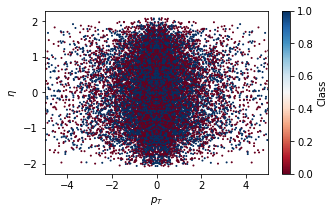

In [26]:
plt.figure(figsize=(5,3))
plt.scatter(x_data[:Ntry,0,0],x_data[:Ntry,0,1],s=1,c=y_data[:Ntry],cmap='RdBu')#,vmin=0.,vmax=1.)
plt.scatter(-x_data[:Ntry,0,0],x_data[:Ntry,0,1],s=1,c=y_data[:Ntry],cmap='RdBu')#,vmin=0.,vmax=1.)
plt.xlabel('$p_T$')
plt.ylabel('$\eta$')
plt.xlim(-5,5)
plt.title('')
plt.colorbar(label='Class')

In [27]:
unique_particles = np.unique(x_data[:Ntry,:,3])

In [28]:
unique_particles

array([-2212., -2112.,  -321.,  -211.,   -13.,   -11.,     0.,    11.,
          13.,    22.,   130.,   211.,   321.,  2112.,  2212.])

In [29]:
for i,particle in enumerate(unique_particles):
    if particle!=0:
        symbol =Particle.from_pdgid(particle).name
        mass = Particle.from_pdgid(particle).mass/1000
        print(i,particle,symbol,mass)

0 -2212.0 p~ 0.93827208816
1 -2112.0 n~ 0.9395654204999999
2 -321.0 K- 0.49367700000000003
3 -211.0 pi- 0.13957039000000002
4 -13.0 mu+ 0.1056583755
5 -11.0 e+ 0.0005109989499999999
7 11.0 e- 0.0005109989499999999
8 13.0 mu- 0.1056583755
9 22.0 gamma 0.0
10 130.0 K(L)0 0.49761099999999997
11 211.0 pi+ 0.13957039000000002
12 321.0 K+ 0.49367700000000003
13 2112.0 n 0.9395654204999999
14 2212.0 p 0.93827208816


In [30]:
#np.save('masses.npy',masses)

## Preprocess Data

1. We will utlize a package called particle in order to find the particle masses based on their pdgid's.
2. We will take the given features $p_T,y,\phi$ to create new physically realizable features including the 

$\bf\text{Transverse Mass Per Multiplicity ($m_{T,ij}$)}$
$$m_{T,ij} = \sqrt{m_{ij}^2 + p_{T,ij}^2}$$
$\bf\text{Energy Per Multiplicity ($E_{ij}$)}$
$$E_{ij} = m_{T,ij} \text{cosh} y_{ij}$$
$\bf\text{Energy Per Jet ($E_i$)}$
$$E_i = \sum_j E_{ij}$$
$\bf\text{Kinematic Momenta Components Per Multiplicity ($\vec{p}_{ij} = (p_{x,ij},p_{y,ij},p_{z,ij})$)} \equiv (N,M,3)$ 
$$p_{x,ij} = p_{T,ij} \text{cos} \phi$$
$$p_{y,ij} = p_{T,ij} \text{sin} \phi$$
$$p_{z,ij} = m_{T,ij} \text{sinh} y_{ij}$$
$\bf\text{Kinematic Momenta Components Per Jet ($\vec{p}_{i} = (p_{x,i},p_{y,i},p_{z,i})$)} \equiv (N,3)$ 
$$\vec{p}_{i} = \sum_j \vec{p}_{ij}$$
$\bf\text{Transverse Momenta Per Jet ($p_{T,i} = |(p_{x,i},p_{y,i})|$)} \equiv (N,1)$ 
$$\vec{p}_{i} = \sqrt{ \sum_{x,y}\left(\sum_j \vec{p}_{ij} \right)^2}$$
$\bf\text{Mass Per Jet ($m_{i}$)} \equiv (N,1)$ 
$$m_{i} = \sqrt{ (E_i - \vec{p}_{i} \cdot \vec{p}_{i} )^2}$$
$\bf\text{Rapidity Per Jet ($y_{i}$)} \equiv (N,1)$ 
$$y_{i} =\frac{1}{2}\ln \left( \frac{E_i + p_{z,i}}{E_i - p_{z,i}} \right)$$
2. Make Edges: Connect three nearest neighbors via invariant mass between particles 

$$m_{ij} = \left( E_{i} - E_{j} \right)^2 - \left( \vec{p}_{i} - \vec{p}_{j} \right)^2$$

Add masses, energy, and three momentum components to node features.

In [31]:
# masses = torch.tensor(np.load('masses.npy'))

In [32]:
print('--- Finding All Unique Particles ---')
unique_particles = np.unique(x_data[:Ntry,:,3])
print()
print('--- Inserting Masses ---')
masses = np.zeros((x_data[:Ntry].shape[0],x_data[:Ntry].shape[1]))
for i,particle in tqdm(enumerate(unique_particles)):
    if particle!=0:
        mass = Particle.from_pdgid(particle).mass/1000
        inds = np.where(particle==x_data[:Ntry,:,3])
        masses[inds]=mass # GeV
print()
print('--- Calculating Momenta and Energies ---')
#theta = torch.arctan(torch.exp(-X[:,:,1]))*2 # polar angle
pt        = x_data[:Ntry,:,0]     # transverse momentum
rapidity  = x_data[:Ntry,:,1]     # rapidity
phi       = x_data[:Ntry,:,2]     # azimuthal angle

mt        = np.sqrt(pt**2+masses**2) # Transverse mass
energy    = mt*np.cosh(rapidity) # Energy per multiplicity bin
e_per_jet = energy.sum(axis=1)  # total energy per jet summed across multiplicity bins

px = pt*np.cos(phi)  # momentum in x
py = pt*np.sin(phi)  # momentum in y
pz = mt*np.sinh(rapidity)  # momentum in z

# three momentum
p = np.stack(( px[:,:,None],  
                 py[:,:,None],
                 pz[:,:,None]), axis=2 )

p_per_jet        = np.sum(p,axis=1)  # total componet momentum per jet
#pt_per_Mbin      = np.sqrt(np.sum(p_per_jet[:,:2]**2, axis=1))  # transverse momentum per jet
#mass_per_jet     = np.sqrt(e_per_jet**2-np.sum(p_per_jet**2,axis=1)) # mass per jet
#rapidity_per_jet = np.log( (e_per_jet+p_per_jet[:,2])/(e_per_jet-p_per_jet[:,2]) )/2  # rapidity per jet from analytical formula
#end_multiplicity_indx_per_jet = np.sum(pt!=0,axis=1).int() # see where the jet (graph) ends

--- Finding All Unique Particles ---

--- Inserting Masses ---


15it [00:00, 66.28it/s]



--- Calculating Momenta and Energies ---


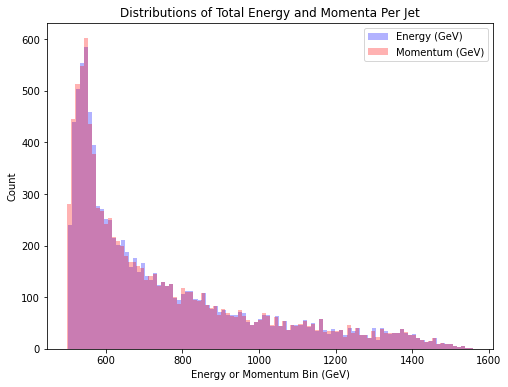

In [33]:
plt.figure(figsize=(8,6))
plt.hist(e_per_jet, color='b', alpha=0.3, bins=100, label='Energy (GeV)')
plt.hist(np.sqrt(np.sum((p_per_jet)**2,axis=1)), color='r', alpha=0.3, bins=100,label='Momentum (GeV)')
plt.title('Distributions of Total Energy and Momenta Per Jet')
plt.xlabel('Energy or Momentum Bin (GeV)')
plt.ylabel('Count')
plt.legend()
plt.show()

In [34]:
def preprocess(x_data,y_data): #,masses):
    print('--- Finding All Unique Particles ---')
    unique_particles = np.unique(x_data[:,:,3])
    x_data = torch.tensor(x_data)
    y_data = torch.tensor(y_data)
    print()
    print('--- Inserting Masses ---')
    masses = torch.zeros((x_data.shape[0],x_data.shape[1]))
    for i,particle in tqdm(enumerate(unique_particles)):
        if particle!=0:
            mass = Particle.from_pdgid(particle).mass/1000
            inds = torch.where(particle==x_data[:,:,3])
            masses[inds]=mass # GeV
    print()
    print('--- Calculating Momenta and Energies ---')
    #theta = torch.arctan(torch.exp(-X[:,:,1]))*2 # polar angle
    pt        = x_data[:,:,0]     # transverse momentum
    rapidity  = x_data[:,:,1]     # rapidity
    phi       = x_data[:,:,2]     # azimuthal angle
    
    mt        = (pt**2+masses**2).sqrt() # Transverse mass
    energy    = mt*torch.cosh(rapidity) # Energy per multiplicity bin
    e_per_jet = energy.sum(axis=1)  # total energy per jet summed across multiplicity bins

    px = pt*torch.cos(phi)  # momentum in x
    py = pt*torch.sin(phi)  # momentum in y
    pz = mt*torch.sinh(rapidity)  # momentum in z
    
    # three momentum
    p  = torch.cat(( px[:,:,None],  
                     py[:,:,None],
                     pz[:,:,None]), dim=2 )

    p_per_jet        = (p).sum(axis=1)  # total componet momentum per jet
    pt_per_Mbin      = (p_per_jet[:,:2]**2).sum(axis=1).sqrt()  # transverse momentum per jet
    mass_per_jet     = (e_per_jet**2-(p_per_jet**2).sum(axis=1)).sqrt() # mass per jet
    rapidity_per_jet = torch.log( (e_per_jet+p_per_jet[:,2])/(e_per_jet-p_per_jet[:,2]) )/2  # rapidity per jet from analytical formula
    end_multiplicity_indx_per_jet = (pt!=0).sum(axis=1).int() # see where the jet (graph) ends
    
    x_data = torch.cat( ( x_data[:,:,:2],
                          x_data[:,:,4:],
                          masses[:,:,None],
                          energy[:,:,None],
                          p), dim=2)
    
    x_data_max = (x_data.max(dim=1).values).max(dim=0).values
    x_data = x_data/x_data_max

    print()
    print('--- Calculating Edge Tensors ---')
    N = x_data[:,0,3].shape[0]  # number of jets (graphs)
    M = x_data[0,:,3].shape[0]  # number of max multiplicty
    connections = 3
    edge_tensor = torch.zeros((N,M,M))
    edge_indx_tensor = torch.zeros((N,2,M*(connections+1))) # M*(connections+1) is the max number of edges we allow per jet
    edge_attr_matrix = torch.zeros((N,M*(connections+1),1)) 
    for jet in tqdm(range(N)):
        stop_indx = end_multiplicity_indx_per_jet[jet] # stop finding edges once we hit zeros
        if end_multiplicity_indx_per_jet[jet]>3:
            for m in range(end_multiplicity_indx_per_jet[jet]):
                inds_edge = np.argsort((energy[jet,m]+energy[jet,:stop_indx])**2-torch.sum((p[jet,m,:stop_indx]+p[jet,:stop_indx,:])**2,axis=1))[:connections]
                edge_tensor[jet,m,inds_edge] = (energy[jet,m]+energy[jet,inds_edge])**2-torch.sum((p[jet,m,:]+p[jet,inds_edge,:])**2,axis=1)
                edge_tensor[jet,m,m]=((energy[jet,m]+energy[jet,m])**2-torch.sum((p[jet,m,:]+p[jet,m,:])**2,axis=0))
            edges_exist_at = torch.where(edge_tensor[jet,:,:].abs()>0)
            edge_indx_tensor[jet,:,:(edge_tensor[jet,:,:].abs()>0).sum()] = torch.cat((edges_exist_at[0][None,:],edges_exist_at[1][None,:]),dim=0).reshape((2,edges_exist_at[0].shape[0]))   
            edge_attr_matrix[jet,:(edge_tensor[jet,:,:].abs()>0).sum(),0]  =  edge_tensor[jet,edges_exist_at[0],edges_exist_at[1]].flatten()

    end_edges_indx_per_jet = (edge_attr_matrix!=0).sum(axis=1).int()
    keep_inds =  np.where(end_edges_indx_per_jet!=0)[0]
    graph_help = torch.cat( ( (energy.max(axis=1).values/e_per_jet).reshape(x_data[:,0,3].shape[0],1),
                              (mass_per_jet).reshape(x_data[:,0,3].shape[0],1),
                              (end_multiplicity_indx_per_jet).reshape(x_data[:,0,3].shape[0],1).int(),
                              (end_edges_indx_per_jet).reshape(x_data[:,0,3].shape[0],1).int() ), dim=1)
        
    return x_data[keep_inds], y_data[keep_inds].long(), edge_tensor[keep_inds], edge_indx_tensor[keep_inds].long(), edge_attr_matrix[keep_inds], graph_help[keep_inds]

In [35]:
N=200000
rng = default_rng(seed=0)
indices = rng.choice(x_data.shape[0], size=N, replace=False)
x_data_proc, y_data_proc, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help = preprocess(x_data[indices],y_data[indices]) #,masses[:N])
N = x_data_proc.shape[0]

--- Finding All Unique Particles ---

--- Inserting Masses ---


15it [00:02,  7.21it/s]



--- Calculating Momenta and Energies ---

--- Calculating Edge Tensors ---


100%|██████████| 200000/200000 [56:41<00:00, 58.80it/s]  


In [36]:
# Check to see if we have the same number of types of particles per jet
#unique_ptypes_per_jet = [ np.unique(x[i,:,3]).shape[0] for i in range(x.shape[0]) ]

In [37]:
# l=0
# max_val = 0
# for i in range(np.where(x[l,:,1]==0)[0][0]):
#     for j in range(np.where(x[l,:,1]==0)[0][0]):
#         val=np.sqrt((x[l,i,1:3]-x[l,j,1:3])**2).sum(axis=0)
#         if val>max_val:
#             max_val = val

In [38]:
# max_val

In [39]:
# d_matrix = np.zeros((x[:,0,3].shape[0],x[0,:,3].shape[0],x[0,:,3].shape[0]))
# for l in tqdm(range(x[:,0,3].shape[0])):
#     for i in range(x[l,:,3].shape[0]):
#         inds_edge = np.where(x[l,i,3]==x[l,:,3])
#         d_matrix[l,i,inds_edge] = np.sqrt((x[l,i,1:3]-x[l,inds_edge,1:3])**2).sum(axis=0))
#     d_matrix[l,:,:]+=np.identity(x[0,:,3].shape[0])

In [40]:
#np.save('edge_matrix.npy',d_matrix)

In [41]:
#d_matrix = np.load('edge_matrix.npy')

In [42]:
#d_matrix.shape

## Preprocess data

In [43]:
# x.max(axis=1).max(axis=0).shape

In [44]:
# def process(feature_data,class_labels,feature_data_max=None):
#     # Normalize features
#     feature_data_max = feature_data.max(axis=1).max(axis=0)
#     feature_data = feature_data/feature_data_max[:]
#     feature_data = torch.tensor(feature_data)[:,:,:]
#     class_labels = torch.tensor(class_labels)[:]
#     return feature_data, class_labels

In [45]:
# x_data, y_data = process(x,y)

In [46]:
print('----- Check for the correctly sized tensors -----')
print()
print(f'Jet Data: {x_data_proc.shape}')
print(f'Classification: {y_data_proc.shape}')
print(f'Full Edge Information: {edge_tensor.shape}')
print(f'Edge Index Information: {edge_indx_tensor.shape}')
print(f'Edge Attribute Information: {edge_attr_matrix.shape}')
print(f'Graph Structure Information: {graph_help.shape}')
print('\n')
print('----- Check that each tensor is normalized -----')
print()
print(f'Jet Data max: {torch.max(x_data_proc)}')
print(f'Classification: {torch.max(y_data_proc)}')

----- Check for the correctly sized tensors -----

Jet Data: torch.Size([199984, 148, 7])
Classification: torch.Size([199984])
Full Edge Information: torch.Size([199984, 148, 148])
Edge Index Information: torch.Size([199984, 2, 592])
Edge Attribute Information: torch.Size([199984, 592, 1])
Graph Structure Information: torch.Size([199984, 4])


----- Check that each tensor is normalized -----

Jet Data max: 1.0
Classification: 1


In [47]:
print('----- Check the structure of the dataset -----')
print()
print(f'Number of graphs (jets): {x_data_proc.shape[0]}')
print(r'Number of features per node (p_T(M),y,phi,m,E,px,py,pz): '+f'{x_data_proc.shape[2]}')
print(f'Number of classes (2: Quarks or Gluons): {np.unique(y_data_proc).shape[0]}')
print()
print('----- Check the structure of one graph -----')
print()
i=0
number_of_edges = graph_help[i,3]
# Gather some statistics about the first graph.
print(f'Number of nodes (particle IDs): {x_data_proc[i,:,0].shape[0]}')
print(f'Number of edges: {number_of_edges}')
print(f'Average node degree: {number_of_edges / x_data_proc[i,:,0].shape[0]:.2f}')
print(f'Is undirected: {True}')

----- Check the structure of the dataset -----

Number of graphs (jets): 199984
Number of features per node (p_T(M),y,phi,m,E,px,py,pz): 7
Number of classes (2: Quarks or Gluons): 2

----- Check the structure of one graph -----

Number of nodes (particle IDs): 148
Number of edges: 120.0
Average node degree: 0.81
Is undirected: True


In [48]:
# Create a dataset class
class Create_Dataset(Dataset):
    def __init__(self, edge_index, x, edge_attr, y, graph_info, transform=None):
        self.edge_index = edge_index
        self.x          = x
        self.edge_attr  = edge_attr
        self.y          = y
        self.graph_info = graph_info
        self.transform  = transform
    
    def __len__(self):
        return self.y.shape[0]
        
    # Could also just define an x,y,z then pass these variables
    # in the training functions over the loop for batch (actually think that way is easier to read)
    def __getitem__(self, index):
        sample = {'edge_index': self.edge_index[index,:,:self.graph_info[index,3]],
                'x': self.x[index,:int(self.graph_info[index,2]),:],
                'edge_attr': self.edge_attr[index,:self.graph_info[index,3]],
                'y': self.y[index] }

        if self.transform is not None:          
            sample = self.transform(sample)
        return sample

In [49]:
train_index   = int(N*0.8)
batch_size = 64
# Create Datasets for Torch for the training and testing pahses
dataset = []
for i in tqdm(range(N)):
    dataset.append(Data(edge_index=edge_indx_tensor[i,:,:int(graph_help[i,3])],x=x_data_proc[i,:int(graph_help[i,2]),:],edge_attr=edge_attr_matrix[i,:int(graph_help[i,3])],y=y_data_proc[i]))
training_data = dataset[:train_index]
test_data     = dataset[train_index:]
# Create data loaders
train_dataloader = DataLoader(training_data, 
                              batch_size = batch_size,
                              shuffle = True, 
                              num_workers = 0)

test_dataloader  = DataLoader(test_data, 
                              batch_size = batch_size,
                              shuffle = False, 
                              num_workers = 0)

print(f'Number of training graphs: {train_index}')
print(f'Number of test graphs: {indices.shape[0]-train_index}')


# for step, data in enumerate(train_dataloader):
#     print(f'Step {step + 1}:')
#     print('=======')
#     print(f'Number of graphs in the current batch: {data.num_graphs}')
#     print(data)
#     print()

100%|██████████| 199984/199984 [00:19<00:00, 10284.67it/s]

Number of training graphs: 159987
Number of test graphs: 40013


In [50]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Architecture 1: Graph Convolutional Network (GCN)

In [51]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels,num_of_features,num_of_classes):
        super(GCN, self).__init__()

        self.gcnn = Sequential('x, edge_index, batch', #edge_attr, batch) 
                               [ (nn.Dropout(p=0.2), 'x -> x'),
                                (GCNConv(in_channels=num_of_features, out_channels=hidden_channels), 'x, edge_index-> x1'),
                                nn.ReLU(inplace=True),
                                (GCNConv(in_channels=hidden_channels, out_channels=hidden_channels), 'x1, edge_index -> x2'),
                                nn.ReLU(inplace=True),
                                (GCNConv(in_channels=hidden_channels, out_channels=hidden_channels), 'x1, edge_index -> x2'),
                                (global_mean_pool, 'x2, batch -> x'),# Mean Pooling Layer to Latent Space
                               ])
        
        self.reduce = nn.Linear(in_features=hidden_channels, out_features=num_of_classes)
            
    def forward(self, x, edge_index,batch):# data.edge_attr, data.batch) 
        # Extract Node Embeddings
        x = self.gcnn(x, edge_index, batch)# data.edge_attr, data.batch) 
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.reduce(x)
        return x

In [52]:
def train_on_dataset(model,loss_fn,train_loader):
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
        pred = model(data.x, data.edge_index, data.batch)# data.edge_attr, data.batch)   # Perform a single forward pass.
        loss = loss_fn(pred, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return loss
    

def test_on_dataset(model,dataloader):
    model.eval()
    num_correct = 0
    size = len(dataloader.dataset)
    for data in dataloader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)# data.edge_attr, data.batch) 
        loss = loss_fn(out, data.y)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        num_correct += (pred==data.y).sum().int()  # Check against true labels.
    return loss, num_correct / size  # Derive ratio of correct predictions.

def train(model,optimizer,loss_fn,train_dataloader,test_dataloader,epochs):
    history = {'train_loss': [],'test_loss':[],'train_accuracy': [],'test_accuracy':[]} 
    best_val_loss = torch.inf
    best_val_acc = 0.
    start = time()
    for i in range(epochs):
        loss = train_on_dataset(model,loss_fn,train_dataloader)
        train_loss, train_acc = test_on_dataset(model,train_dataloader)
        test_loss, test_acc = test_on_dataset(model,test_dataloader)

        history['train_loss'].append(train_loss.data.item())
        history['test_loss'].append(test_loss.data.item())
        history['train_accuracy'].append(train_acc.data.item())
        history['test_accuracy'].append(test_acc.data.item())
        
        if best_val_acc<train_acc:
        #if train_loss < best_val_loss:
            best_val_acc = train_acc
            best_val_loss = train_loss
            best_model = copy.deepcopy(model)
            best_model_wts = copy.deepcopy(model.state_dict())
            
#         if i<9:
#             print(f'Epoch {i+1}   |  Train Loss: {train_loss:>8f}  |  Train Acc: {train_acc:>4f} | Test Acc: {test_acc:.4f}')
#         else:
#             print(f'Epoch {i+1}  |  Train Loss: {train_loss:>8f}  |  Train Acc: {train_acc:>4f} | Test Acc: {test_acc:.4f}')
        if i<9:
            print(f'Epoch {i+1}   |  Train Loss: {train_loss:>4f} | Test Loss: {test_loss:.4f}  |  Train Acc: {train_acc:>4f} | Test Acc: {test_acc:.4f}')
        else:
            print(f'Epoch {i+1}  |  Train Loss: {train_loss:>4f} | Test Loss: {test_loss:.4f}  |  Train Acc: {train_acc:>4f} | Test Acc: {test_acc:.4f}')

    end = time()
    total_time = end-start
    print(f"Time: {total_time:.5f} sec")  #|  Best Loss: {best_val_loss:.5f}")
    print("Complete.")
    return {'model': best_model,'history': history}

In [53]:
torch.manual_seed(0)
number_of_hidden_channels = batch_size
num_of_features = x_data_proc.shape[2]
num_of_classes  = np.unique(y_data_proc).shape[0]
lr = 5e-3
model = GCN(hidden_channels=number_of_hidden_channels,
            num_of_features=num_of_features,
            num_of_classes=num_of_classes)
print(model)


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()
epochs= 50
training = train(model=model,
                 optimizer=optimizer,
                 loss_fn=loss_fn,
                 train_dataloader=train_dataloader,
                 test_dataloader=test_dataloader,
                 epochs=epochs)

GCN(
  (gcnn): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): GCNConv(7, 64)
    (2): ReLU(inplace=True)
    (3): GCNConv(64, 64)
    (4): ReLU(inplace=True)
    (5): GCNConv(64, 64)
    (6): <function global_mean_pool at 0x7f9ad0951160>
  )
  (reduce): Linear(in_features=64, out_features=2, bias=True)
)
Epoch 1   |  Train Loss: 0.595077 | Test Loss: 0.5145  |  Train Acc: 0.769425 | Test Acc: 0.7681
Epoch 2   |  Train Loss: 0.604986 | Test Loss: 0.5137  |  Train Acc: 0.768500 | Test Acc: 0.7684
Epoch 3   |  Train Loss: 0.490807 | Test Loss: 0.5564  |  Train Acc: 0.754249 | Test Acc: 0.7549
Epoch 4   |  Train Loss: 0.588315 | Test Loss: 0.5559  |  Train Acc: 0.751780 | Test Acc: 0.7517
Epoch 5   |  Train Loss: 0.486906 | Test Loss: 0.5152  |  Train Acc: 0.770569 | Test Acc: 0.7694
Epoch 6   |  Train Loss: 0.386846 | Test Loss: 0.6280  |  Train Acc: 0.727634 | Test Acc: 0.7278
Epoch 7   |  Train Loss: 0.497318 | Test Loss: 0.5823  |  Train Acc: 0.734085 | Test Acc: 0.7346
Ep

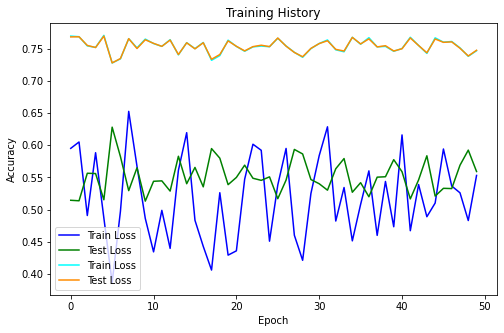

In [54]:
# Plot the training accuracy
fig = plt.figure(figsize=(8,5))
plt.plot(training['history']['train_loss'],c='b',label='Train Loss')
plt.plot(training['history']['test_loss'],c='g',label='Test Loss')
plt.plot(training['history']['train_accuracy'],c='cyan',label='Train Loss')
plt.plot(training['history']['test_accuracy'],c='darkorange',label='Test Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [55]:
model = copy.deepcopy(training['model'])
model.eval()
num_correct = 0
size = len(test_dataloader.dataset)
# Compare to initialized test_data = y_data_proc[train_index:]
test_predicitons = torch.zeros((len(test_data),1))
for i,data in tqdm(enumerate(test_dataloader)):  # Iterate in batches over the training/test dataset.
    out = model(data.x, data.edge_index, data.batch)  
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    num_correct += (pred==data.y).sum().int()
    if len(test_data)<(i+1)*batch_size:
        test_predicitons[i*batch_size:] = pred.reshape((len(test_data)-i*batch_size,1))
    else:
        test_predicitons[i*batch_size:(i+1)*batch_size] = pred.reshape((batch_size,1))
print('Accuracy for GCN: ',num_correct/size)

625it [00:11, 54.86it/s]

Accuracy for GCN:  tensor(0.7694)


In [56]:
print(train_index)
print(len(test_data))

159987
39997


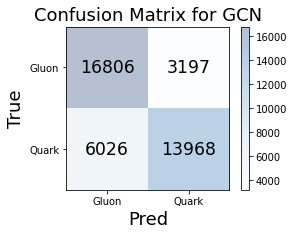

In [57]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_data_proc[train_index:], y_pred=test_predicitons)
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(4, 3))
im = ax.imshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Pred', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('Confusion Matrix for GCN', fontsize=18)
plt.xticks(ticks=[0,1],labels=['Gluon','Quark'])
plt.yticks(ticks=[0,1],labels=['Gluon','Quark'])
plt.colorbar(im)
plt.show()

## Architecture 2: Graph Convolutional Attention Network (GCAT)

In [58]:
class GAT(nn.Module):
    def __init__(self, hidden_channels, number_of_features, number_of_classes, dropout1, dropout2, number_attention_heads):
        super(GAT, self).__init__()
        self.dropout1 = dropout1
        self.dropout2 = dropout2
        #self.in_att = Sequential('x, edge_index, batch',[(GATConv(in_channels = number_of_features, out_channels = hidden_channels, dropout2=dropout2, concat=True), 'x, edge_index -> x1')
        self.attentions = [ Sequential('x, edge_index, edge_attr, batch',[(GATConv(in_channels = number_of_features, out_channels = hidden_channels, dropout2=dropout2, concat=True), 'x, edge_index, edge_attr -> x')]) for _ in range(number_attention_heads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)
            
    
#         self.out_att = Sequential('x, edge_index, batch',[(GATConv(in_channels = number_of_hidden_channels*number_attention_heads, out_channels = hidden_channels, dropout2=dropout2, concat=False), 'x, edge_index -> x1')])
        self.out_att = Sequential('x, edge_index, edge_attr, batch',[(GATConv(in_channels = number_of_hidden_channels*number_attention_heads, out_channels = hidden_channels, dropout2=dropout2, concat=False), 'x, edge_index, edge_attr -> x')])

#         self.pool = Sequential('x, edge_index, edge_attr, batch',      
#                            [(global_mean_pool, 'x, batch -> x'),# Mean Pooling Layer to Latent Space
#                            ]) 
        self.gat = Sequential('x, edge_index, edge_attr, batch', 
                               [(GATConv(in_channels = number_of_hidden_channels, out_channels = hidden_channels, dropout2=dropout2, concat=False), 'x, edge_index, edge_attr -> x1'),
                                nn.ReLU(inplace=True),
                                (GATConv(in_channels = number_of_hidden_channels, out_channels = hidden_channels, dropout2=dropout2, concat=False), 'x1, edge_index, edge_attr -> x2'),
                                nn.ReLU(inplace=True),
                                (GATConv(in_channels = number_of_hidden_channels, out_channels = hidden_channels, dropout2=dropout2, concat=False), 'x2, edge_index, edge_attr -> x3'),
                                nn.ReLU(inplace=True),
                                (GATConv(in_channels = number_of_hidden_channels, out_channels = hidden_channels, dropout2=dropout2, concat=False), 'x3, edge_index, edge_attr -> x4'),
                                (global_mean_pool, 'x4, batch -> x'),
                               ])

#         self.gcnn = Sequential('x, edge_index, batch', 
#                                [(GCNConv(in_channels=hidden_channels, out_channels=hidden_channels), 'x, edge_index -> x1'),
#                                 nn.ReLU(inplace=True),
#                                 (GCNConv(in_channels=hidden_channels, out_channels=hidden_channels), 'x1, edge_index -> x2'),
#                                 (global_mean_pool, 'x2, batch -> x'),# Mean Pooling Layer to Latent Space
#                                ])
        
        self.reduce = nn.Linear(in_features=hidden_channels, out_features=num_of_classes)
        
    def forward(self, x, edge_index, edge_attr, batch):#adj):
        x = F.dropout(x, p=self.dropout2, training=self.training)
#         x = self.in_att(x, edge_index, batch)
#         for att in self.attentions:
        x = torch.cat([att(x, edge_index, edge_attr, batch) for att in self.attentions],dim=1)
        x = F.dropout(x, self.dropout2, training=self.training)
        x = self.out_att(x, edge_index, edge_attr, batch)
#         x = self.pool(x, edge_index, edge_attr, batch)
#         x = self.reduce(x)
#         x = F.elu(x)
#         x = self.pool(x,edge_index,batch)
        x = self.gat(x, edge_index, edge_attr, batch)
#         x = F.elu(x)
#         x = self.gcnn(x, edge_index, batch)
#         x = F.dropout(x, p=self.dropout2, training=self.training)
        x = self.reduce(x)
        x = F.elu(x)
        return F.log_softmax(x, dim=1)

In [59]:
def train_on_dataset_GAT(model,loss_fn,train_loader):
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
        pred = model(data.x, data.edge_index, data.edge_attr, data.batch)# data.edge_attr, data.batch)   # Perform a single forward pass.
        loss = loss_fn(pred, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return loss
    

def test_on_dataset_GAT(model,dataloader):
    model.eval()
    num_correct = 0
    size = len(dataloader.dataset)
    for data in dataloader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)# data.edge_attr, data.batch) 
        loss = loss_fn(out, data.y)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        num_correct += (pred==data.y).sum().int()  # Check against true labels.
    return loss, num_correct / size  # Derive ratio of correct predictions.

def train_GAT(model,optimizer,loss_fn,train_dataloader,test_dataloader,epochs):
    history = {'train_loss': [],'test_loss':[],'train_accuracy': [],'test_accuracy':[]} 
    best_val_loss = torch.inf
    best_val_acc = 0.
    start = time()
    for i in range(epochs):
        loss = train_on_dataset_GAT(model,loss_fn,train_dataloader)
        train_loss, train_acc = test_on_dataset_GAT(model,train_dataloader)
        test_loss, test_acc = test_on_dataset_GAT(model,test_dataloader)

        history['train_loss'].append(train_loss.data.item())
        history['test_loss'].append(test_loss.data.item())
        history['train_accuracy'].append(train_acc.data.item())
        history['test_accuracy'].append(test_acc.data.item())
        
        if best_val_acc<train_acc:
        #if train_loss < best_val_loss:
            best_val_acc = train_acc
            best_val_loss = train_loss
            best_model = copy.deepcopy(model)
            best_model_wts = copy.deepcopy(model.state_dict())
            
#         if i<9:
#             print(f'Epoch {i+1}   |  Train Loss: {train_loss:>8f}  |  Train Acc: {train_acc:>4f} | Test Acc: {test_acc:.4f}')
#         else:
#             print(f'Epoch {i+1}  |  Train Loss: {train_loss:>8f}  |  Train Acc: {train_acc:>4f} | Test Acc: {test_acc:.4f}')
        if i<9:
            print(f'Epoch {i+1}   |  Train Loss: {train_loss:>4f} | Test Loss: {test_loss:.4f}  |  Train Acc: {train_acc:>4f} | Test Acc: {test_acc:.4f}')
        else:
            print(f'Epoch {i+1}  |  Train Loss: {train_loss:>4f} | Test Loss: {test_loss:.4f}  |  Train Acc: {train_acc:>4f} | Test Acc: {test_acc:.4f}')

    end = time()
    total_time = end-start
    print(f"Time: {total_time:.5f} sec")  #|  Best Loss: {best_val_loss:.5f}")
    print("Complete.")
    return {'model': best_model,'history': history}

In [65]:
torch.manual_seed(0)
number_of_hidden_channels = batch_size
num_of_features = x_data_proc.shape[2]
num_of_classes  = np.unique(y_data_proc).shape[0]
number_attention_heads = 8
dropout1 = 0.15
dropout2 = 0.4
lr = 5e-3
model = GAT(number_of_features=num_of_features, 
            hidden_channels=number_of_hidden_channels, 
            number_of_classes=num_of_classes, 
            dropout1=dropout1, 
            dropout2=dropout2,
            number_attention_heads=number_attention_heads)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss() #F.nll_loss()
epochs= 12
training = train_GAT(model=model,
                 optimizer=optimizer,
                 loss_fn=loss_fn,
                 train_dataloader=train_dataloader,
                 test_dataloader=test_dataloader,
                 epochs=epochs)

GAT(
  (attention_0): Sequential(
    (0): GATConv(7, 64, heads=1)
  )
  (attention_1): Sequential(
    (0): GATConv(7, 64, heads=1)
  )
  (attention_2): Sequential(
    (0): GATConv(7, 64, heads=1)
  )
  (attention_3): Sequential(
    (0): GATConv(7, 64, heads=1)
  )
  (attention_4): Sequential(
    (0): GATConv(7, 64, heads=1)
  )
  (attention_5): Sequential(
    (0): GATConv(7, 64, heads=1)
  )
  (attention_6): Sequential(
    (0): GATConv(7, 64, heads=1)
  )
  (attention_7): Sequential(
    (0): GATConv(7, 64, heads=1)
  )
  (out_att): Sequential(
    (0): GATConv(512, 64, heads=1)
  )
  (gat): Sequential(
    (0): GATConv(64, 64, heads=1)
    (1): ReLU(inplace=True)
    (2): GATConv(64, 64, heads=1)
    (3): ReLU(inplace=True)
    (4): GATConv(64, 64, heads=1)
    (5): ReLU(inplace=True)
    (6): GATConv(64, 64, heads=1)
    (7): <function global_mean_pool at 0x7f9ad0951160>
  )
  (reduce): Linear(in_features=64, out_features=2, bias=True)
)
Epoch 1   |  Train Loss: 0.514236 | Tes

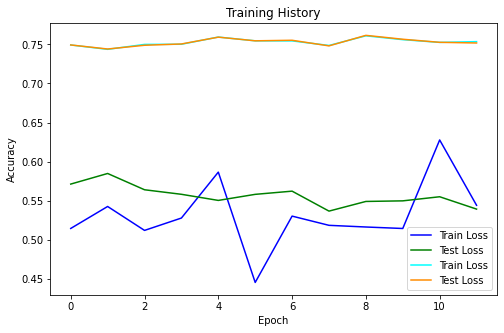

In [66]:
# Plot the training accuracy
fig = plt.figure(figsize=(8,5))
plt.plot(training['history']['train_loss'],c='b',label='Train Loss')
plt.plot(training['history']['test_loss'],c='g',label='Test Loss')
plt.plot(training['history']['train_accuracy'],c='cyan',label='Train Loss')
plt.plot(training['history']['test_accuracy'],c='darkorange',label='Test Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [67]:
model = copy.deepcopy(training['model'])
model.eval()
num_correct = 0
size = len(test_dataloader.dataset)
# Compare to initialized test_data = y_data_proc[train_index:]
test_predicitons = torch.zeros((len(test_data),1))
for i,data in tqdm(enumerate(test_dataloader)):  # Iterate in batches over the training/test dataset.
    out = model(data.x, data.edge_index, data.edge_attr,data.batch)  
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    num_correct += (pred==data.y).sum().int()
    if len(test_data)<(i+1)*batch_size:
        test_predicitons[i*batch_size:] = pred.reshape((len(test_data)-i*batch_size,1))
    else:
        test_predicitons[i*batch_size:(i+1)*batch_size] = pred.reshape((batch_size,1))
print('Accuracy for GCAT: ',num_correct/size)

625it [01:53,  5.51it/s]

Accuracy for GCAT:  tensor(0.7617)


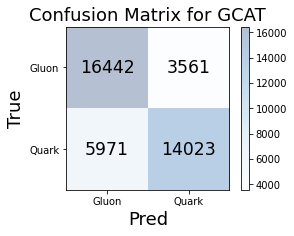

In [68]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_data_proc[train_index:], y_pred=test_predicitons)
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(4, 3))
im = ax.imshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Pred', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('Confusion Matrix for GCAT', fontsize=18)
plt.xticks(ticks=[0,1],labels=['Gluon','Quark'])
plt.yticks(ticks=[0,1],labels=['Gluon','Quark'])
plt.colorbar(im)
plt.show()

## Comparison Between Architecture 1: GCN and Architecture 2: GCAT

Trained each on 160k out of 200k randomly chosen samples from the full 2M jets. Tested on 40k.


I. GCN

1. Optimizer: Adam , $lr = 5 \times 10^{-3}$
2. Loss: Cross Entropy Loss
3. Epochs: $50$
4. Structure: (see print out above)
- Dropout ratio of 0.2
- Three Hidden Graph Convolutional layers
- ReLU activation after the first two
- Global Mean Pooling Layer
- Dropout of 0.5
- Linear layer out
5. Accuracy: 0.7694 (see confusion matrix above)
6. Run time on CPU: 1.5 hours

II. GCAT

1. Optimizer: Adam , $lr = 5 \times 10^{-3}$
2. Loss: Cross Entropy Loss
3. Epochs: $12$
4. Structure: (see print out above)
- Dropout ratio of 0.4
- Attention Network with 8 attention heads
- Droput of 0.4
- Out attention layer
- Four Hidden Feed forward Graph Attention layers
- ReLU activation after the first three
- Global Mean Pooling Layer
- Linear layer out (with functional ELU and softmax applied)
5. Accuracy: 0.7617 (see confusion matrix above)
6. Run time on CPU: 4 hours. Note: Run on GPU.

The standard graph convolutional network (GCN) seemed to perform well with an accuracy of about $77 \%$. Increasing the number of layers in this network was not shown to significantly increase performance. A run time of one and a half hours is quite good with 50 epochs and a training set of 160k samples on a CPU.

The graph attention network (GCAT) performed slightly worse $76\%$ than the GCN over less epochs, $12$.
The attention heads did not seem to be enough to achieve highly accurate results, which is why more attention layers were added in sequence after the attention head output. This network also had a significantly longer training time of about five hours on a CPU.

Optimizing both network hyperparameters was challenging. Training the GCAT over more epochs may have offered a more fair comparison, however, training results seemed to fluctuate about a central best value even over longer training times.

---

# Task III: Open Task on Quantum Computing

1. Please comment on quantum computing or quantum machine learning. You can also comment on one quantum algorithm or one quantum software you are familiar with. You can also suggest methods you think are good and you would like to work on. Please use your own understanding. Comments copied from the internet will not be considered.


$\qquad$ A transition to quantum hardware and software has the potential to considerably accelerate processes within our interconnected devices. From information storage to transaction times to security, quantum computing and quantum machine learning, which are based on the foundations of quantum theory, should be able to significantly outperform classical computers by reducing computational complexity. They do this through the generalization of binary classical computer bits $(0,1)$ to quantum computer qubits (photons, electrons, etc.) which can be altered by gates (e.g. Hadammard, Rotation, Controlled Not, Swap etc.) and take on superpositions and entanglements of $|0\rangle,|1\rangle$ states , allowing for substantially more compute. The first devices to scale up to quantum processors with tens to hundreds of qubits have been noisy intermediate scale quantum devices (NISQ). Companies such as IBM, Google, D-Wave, and iONQ have already developed functional NISQ devices. While these devices have verified the superiority of algorithm's such as Shor's for factorization and Grover's for searching with respect to their order $O$ time complexities, they are subject to disturbances or quantum decoherence, and therefore, the circuit and gates within these circuits, which act on qubits, must be improved.  Many API's, including Google's Cirq, IBM's Qiskit, and Pennylane, also exist for building quantum circuits and quantum machine learning (QML) algorithms to be run on quantum computers.

$\qquad$ The superposition, entanglement, and interference aspects of qubits make them very powerful. Superposition of states allows for states to take on any properly normalized combination of a $|0\rangle$ and $|1\rangle$ state, i.e. $|\psi\rangle = c_1|0\rangle + c_2|1\rangle$ such that $c_1^2 + c_2^2 =1$, rather than either a $0$ or a $1$ in a classical binary system. Superposition allows for the simultaneous measurment of multiple processes (options) in order to optimize a Hamiltonian function (find a solution rapidly) upon measurement. Entanglement allows states to interact with one another leading to strongly correlated systems. By measuring one of these states, information about connected states can also be retrieved. One simple example of such a state is the Bell state, which can be constructed via a simple quantum circuit. Interference allows for the correction of $|0\rangle$ and $|1\rangle$ states for more accurate output results.

$\qquad$ Quantum algorithms which I have worked on to solve NP-Hard problems include the semi-classical quantum unconstrained binary optimization (QUBO) and quantum approximate optimization algorithm (QAOA). These algorithms work well for solving lattice configured or graphically structured data problems, including knapsack, max cut, stable marriage, clustering etc. problems. QUBO's require you to set up an Ising spin function up to quadratic order which labels the weights of each state and the interactions between them. This resembles the formation of an Ising Hamiltonian in quantum mechanics which we seek to minimize the energy (expectation value, $x^\dagger\hat{H}x$) of with respect to a stable configuration of the states $(x_i \in \{0,1\}$ interacting within the system. One such example is of the earth mover's distance Hamiltonian,
$$    H_\text{EMD} = \alpha \sum_{j=1}^N \left(1 - \sum_{i=1}^N X_{ij}\right)^2 + \alpha \sum_{i=1}^N \left(1 - \sum_{j=1}^N X_{ij}\right)^2 + \beta \sum_{i=1}^N \sum_{j=1}^N \omega_{ij} X_{ij}$$
where $X_{ij} \in \{ 0,1\}$, the first two terms attempt to ensure the mapping is one-to-one and onto between points, i.e. every column and row of the array labelling the different points in the graph has a single value of $1$, and the final terms takes into account a weight between points $\omega_{ij}$, e.g. the Euclidean distance in a spatial point graph, which we wish to minimize. These Hamiltonians are easy to convert to quantum unitary, i.e. $U^\dagger U = \mathbb{I}$, operators for a quantum computer to read by first changing the expression to be in terms of the operators which act on the states in our system and exponentiating this with a factor of $-i\alpha$, however, still tend to be too difficult to implement directly. Simplifications can be used to implement them, such as the Trotter expansion. The QAOAs use a similar concept with constraints induced by Hamiltonians of the form above. These quantum algorithms are run on quantum computers and find approximate solutions to combinatorial optimization problems. An integer $p$ determines a specific ansatz for the initial parameters of the QAOA. This ansatz based on $p$ can affect the final solution accuracy, and QAOA can generalize to quantum graph convolutional neural networks.

$\qquad$ The variational quantum eigensolver algorithm and quantum Fourier transform methods, as well as other useful Hamiltonian expansions and decompositions would be useful and interesting to learn beyond this.

---

## Task V: Quantum Graph Neural Network (QGNN) 
In task II you already worked with a classical GNN. 


1. Describe a possibility for a QGNN circuit, which takes advantage of the graph representation of the data
2. Implement and draw the circuit.

[1] Verdon, G., McCourt, T., Luzhnica, E., Singh, V., Leichenauer, S., & Hidary, J. (2019). Quantum Graph Neural Networks. arXiv preprint arXiv:1909.12264.

1. A classical GNN maps a given graph structure into a lower dimensional vector space with characteristic features assigned to nodes and edges. This representation should preserve the topological graph structure, i.e. which nodes are connected, along with the deterministic features of the nodes and attributes of the edges. In the quantum graph structure, classical nodes can be mapped to quantum states, features to the characteristics of the states, edges to the interactions between states, and edge attributes to the strength of the interactions between the quantum states which form the graph. The larger structure of a classical model can then be embedded into the Hamiltonian operator you choose to act on the specified quantum states within the graph which will ultimately determine the dynamics and final state of the quantum algorithm.


## Graph Clustering with Quantum Graph Convolutional Networks
A possibility for a QGNN would be to assign possible states $\{ |0\rangle,|1 \rangle\}$ to each vertex $v$ of the graph $\mathcal{G} = \{ \mathcal{V}, \mathcal{E} \}$ with vertices $v \in \mathcal{V}$ and edges $e \in \mathcal{E}$, i.e. we assign a Hilbert space $\mathcal{H}_{\mathcal{v}}$ to each vertex. One can do the same for the edges $\mathcal{H}_{e}$. It is the collection of these individual spaces, or possible characterization, which can create the global quantum graph structure where $\mathcal{H}_{\mathcal{V}} = \bigotimes_{\mathcal{v}} \mathcal{H}_\mathcal{V}$, $\mathcal{H}_{\mathcal{E}} = \bigotimes_{\mathcal{e}} \mathcal{H}_\mathcal{E}$, and the entire space becomes $$\mathcal{H}_{\mathcal{V} \otimes \mathcal{E}} = \mathcal{H}_{\mathcal{V}} \otimes \mathcal{H}_{\mathcal{E}}$$. 
Each vertex $i$ can be thought of as a qubit with a superposition of states from its respective Hilbert space $\{ |0\rangle,|1 \rangle\} \in \mathcal{H}_i$. 

Now, we must set up our optimization algorithm for the circuit, which will depend on out choice of Hamiltonian. Fortunately, the classical Hamiltonian for a QUBO algorithm is in terms of spins $x_i \in \{0,1\}$, which can be mapped to spins $f(x_i)=(2x_i-1): x_i \to s_i \in \{ -1 , 1\}$, and thus, can be generalized to a quantum operator. The general QUBO optmization function can be written as
$$H_{Classical} (\mathcal{W}_{ij},\mathcal{U}_i,\mathcal{Q}_0,s_i,\mathcal{x}_i) = \sum_{(i,j) \in \mathcal{E}} \mathcal{W}_{ij} s_i s_j + \sum_{i} \mathcal{U}_i s_i + \mathcal{Q}_0\underbrace{\sum_i \mathcal{x}_i}_{Transverse}$$
and can be mapped to an operator via
$$s_i \to \sigma_i^z \equiv Z_i$$
$$\mathcal{x}_i \to \sigma_i^\mathcal{x} \equiv \mathcal{X}_i$$
i.e. the Pauli matrices, where $\mathcal{W}_{ij},\mathcal{U}_i,\mathcal{Q}_0$ are either a priori determined or can be optimized through the algorithm. Our quantum graph-inherited optimization function will take the form
$$H_{Quantum} (\mathcal{W}_{ij},\mathcal{U}_i,\mathcal{Q}_0) = \underbrace{\sum_{(i,j) \in \mathcal{E}} \mathcal{W}_{ij} \sigma_i^z \sigma_j^z}_{Interactions Between Nodes (qubits)} + \underbrace{\sum_{i} \mathcal{U}_i \sigma_i^z}_{Node (qubit) weights} + \mathcal{Q}_0 \underbrace{\sum_i \sigma_i^\mathcal{x}}_{Transverse}$$
By learning an infinitesimal parameter $\gamma_q$, we can turn this Hamiltonian into a unitary transformation to act on the initial state qubits
$$\mathbb{U}(\mathcal{W}_{ij},\mathcal{U}_i,\mathcal{Q}_0,\gamma_q) = \mathbb{I} + (-i)\gamma_q H_{Quantum,q} (\mathcal{W}_{ij},\mathcal{U}_i,\mathcal{Q}_0) + \mathcal{O}(\gamma^2)$$
$$= e^{-i\gamma_q H_{Quantum,q} (\mathcal{W}_{ij},\mathcal{U}_i,\mathcal{Q}_0)}$$
Applying this transformation $Q$ times will correspond to running our network over $Q$ layers. Thus will build up a full trainable parameter transformation
$$\prod_{q=1}^Q \mathbb{U}_q =\prod_{q=1}^Q e^{-i\gamma_q H_{Quantum,q} (\mathcal{W}_{ij},\mathcal{U}_i,\mathcal{Q}_0)} = e^{-i\gamma_q H_{Quantum,q} (\mathcal{W}_{ij},\mathcal{U}_i,\mathcal{Q}_0)}$$
where the final $\gamma_q H_{Quantum,q}$ is to be summed over $q$. We can then take the expectation value of the final evolved state, and minimize this with respect to our graph structure. I will attempt to implement a simple Quantum Graph Convolutional Neural Network (QGCNN) below based on unsupervised graph clustering with two clustewrs. I will take two jet clusters from the Pythia8 dataset up to multiplicity 10 and identify each cluster with respect to the rapidity $\eta$ and azimuthal angle $\phi$ using the Hamiltonian
$$H = \sum_{(i,j)\in\mathcal{E}} d_{ij} \left(\frac{\mathbb{I}_i + \sigma_i^z}{2}\right)\left(\frac{\mathbb{I}_j + \sigma_j^z}{2}\right) + \left(\sum_{i=1}^{qubits} \sigma_i^z \right)^2$$
$$= \frac{1}{4} \sum_{(i,j)\in\mathcal{E}} d_{ij} \left(\mathbb{I}_i\mathbb{I}_j + \mathbb{I}_i\sigma_j^z +\sigma_i^z\mathbb{I}_j + \sigma_i^z\sigma_j^z\right) + \left(\sum_{i=1}^{qubits} \sigma_i^z \right) \times \left(\sum_{i=1}^{qubits} \sigma_i^z \right) $$
$$= \frac{1}{4} \sum_{(i,j)\in\mathcal{E}} d_{ij} \left(\mathbb{I}_i\mathbb{I}_j + \mathbb{I}_i\sigma_j^z +\sigma_i^z\mathbb{I}_j + \sigma_i^z\sigma_j^z\right)  + \sum_{i=1,j=1}^{qubits} \sigma_i^z \sigma_j^z$$
with $n = 4$ qubits, $q=10$ layers, and all possible combinations of edges will be included. The distances will be precomputed as $d_{ij} =\Delta R_{ij} = \sqrt{(\eta_i-\eta_j)^2+(\phi_i-\phi_j)^2}$. The loss used will be that of 
$$\mathcal{L}(\gamma_q) = 1- \frac{1}{N} \sum_{i=1}^{qubits}|\langle \psi_{rotated} | U_i(\theta, \gamma_q) | \psi_0 \rangle |^2$$


The circuit will rotate a low energy state via the weights of the hamiltonian, which we know as we have the location of points in our graph. The model will train on new weights $\mathcal{W}_{qr}$ and rotations $\eta_q$ and act on a set of qubits via coupling and sequential gate actions with a bias, i.e. $(1): I_iI_j,I_iRZ_j,RZ_iI_j,MultiRZ$ with weights for interaction term, $(2): RZ_i,RZ_j$ with bias weights on all combinations of qubits, $(3):RX,RY$ with bias weights on each qubit. Enforce a swap test with a control qubit and find the expectation value of this control qubit with respect to PauliZ (expect a value of 1). Normalize the sum of these iterations over $\eta_q$ by $N_\eta$, the number of angles we iterate over. A $1$ minus this term (our loss) should yeild a result of 0.


It should be noted that to perform the same gluon and jet classification task we will need to use the Graph Isomorphism Classification via Quantum Graph Convolutional Networks from [1] Verdon et al. or egoGraphs via [2] Xing Ai, Luzhe Sun, Junchi Yan, Zhihong Zhang, and Edwin R Hancock, Towards Quantum Graph Neural Networks: An Ego-Graph Learning Approach (2015)

2. See Below

In [374]:
#!pip install --no-cache-dir networkx ipywidgets

In [458]:
import pennylane as qml
from matplotlib import pyplot as plt
from pennylane import numpy as np
import scipy
import networkx as nx
import copy

In [459]:
def get_distance(tuple1,tuple2):
    return np.sqrt((tuple1[0]-tuple2[0])**2+(tuple1[1]-tuple2[1])**2)

Plot of chosen jets for clustering

Text(0, 0.5, 'Azimuthal Angle')

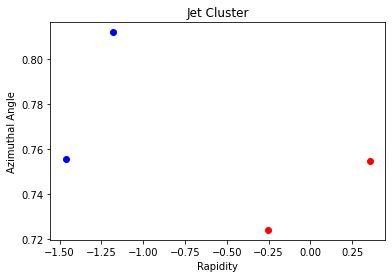

In [460]:
i=0
j=27
M=2
plt.scatter(x_data[i,:M,1],x_data[i,:M,2]/np.pi/2,c='r')
plt.scatter(x_data[j,:M,1],x_data[j,:M,2]/np.pi/2,c='b')
plt.title('Jet Cluster')
plt.xlabel('Rapidity')
plt.ylabel('Azimuthal Angle')

In [461]:
jets_chosen = [0,27]
pos = {M*i%26+j: (x_data[i,j,1]/np.pi/2, x_data[i,j,2]/np.pi/2) for i in jets_chosen for j in range(M)}
make_jet_edges = [ (i,j) for i in pos for j in pos if i<j ]
make_true_edges = [ (i,j) for i in pos for j in pos if (i<M and j<M and i<j) or (i>=M and j>=M and i<j) ]

In [462]:
# number of qubits
qubit_number = M*2
qubits = range(qubit_number)

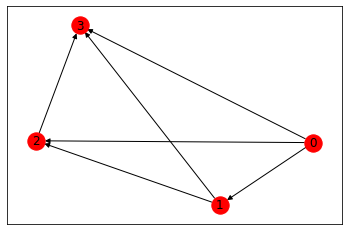

In [463]:
ising_graph = nx.DiGraph()
ising_graph.add_nodes_from(pos)
ising_graph.add_edges_from(make_jet_edges)
nx.draw_networkx(ising_graph, pos, node_color='red', edgelist=make_jet_edges)

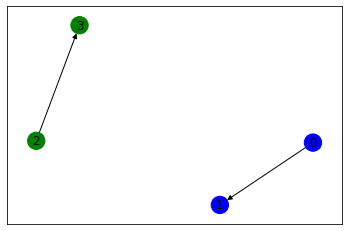

In [464]:
solution_ising_graph = nx.DiGraph()
solution_ising_graph.add_nodes_from(pos)
solution_ising_graph.add_edges_from(make_true_edges)
color_map = []
for node in solution_ising_graph:
    if node < M:
        color_map.append('blue')
    else: 
        color_map.append('green')  
nx.draw_networkx(solution_ising_graph, pos, node_color=color_map, edgelist=make_true_edges)#node_size=60,

In [466]:
# Choose the target parameters by seeing which edges belong to each jet
target_weights = [get_distance(pos[edge[0]],pos[edge[1]])*1000*-1 if edge in solution_ising_graph.edges else 100  for edge in ising_graph.edges]#np.random.uniform(low=-3,high=3,size=2**qubit_number) 
target_bias = [1 for i in range(qubit_number)]
ninteraction_terms=4

In [467]:
def create_hamiltonian_matrix(n_qubits, graph, weights, bias):
    full_matrix = np.zeros((2 ** n_qubits, 2 ** n_qubits))
    # Creates the interaction component of the Hamiltonian
    for term in range(ninteraction_terms):
        for i, edge in enumerate(graph.edges):
            interaction_term = 1#get_distance(pos[edge[0]],pos[edge[1]])
            for qubit in range(0, n_qubits):
                if qubit in edge:
                    if term==0:
                        interaction_term  = np.kron(interaction_term, np.identity(2))#/2
                    elif term==1:
                        if qubit==edge[0]:
                            interaction_term = np.kron(interaction_term, np.identity(2))#/2
                        elif qubit==edge[1]:
                            interaction_term = np.kron(interaction_term, qml.matrix(qml.PauliZ)(0))#/2
                    elif term==2:
                        if qubit==edge[0]:
                            interaction_term = np.kron(interaction_term, qml.matrix(qml.PauliZ)(0))#/2
                        elif qubit==edge[1]:
                            interaction_term = np.kron(interaction_term, np.identity(2))#/2
                    elif term==3:
                        interaction_term = np.kron(interaction_term, qml.matrix(qml.PauliZ)(0))#/2
                else:
                    interaction_term = np.kron(interaction_term, np.identity(2))
            full_matrix += weights[i]*interaction_term
    # Creates the bias components of the matrix
    for i in range(0, n_qubits):
        z_term = 1 #x_term = 1
        for j in range(0, n_qubits):
            z_term = np.kron(z_term, qml.matrix(qml.PauliZ)(0))
        full_matrix += 4*bias[i]*z_term  #+ x_term
    return full_matrix

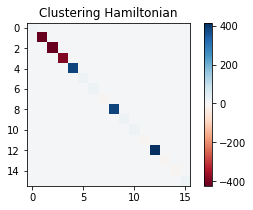

In [468]:
# Prints a visual representation of the Hamiltonian matrix
ham_matrix = create_hamiltonian_matrix(qubit_number, solution_ising_graph, target_weights, target_bias)
plt.figure(figsize=(5,3))
plt.imshow(ham_matrix, cmap="RdBu")
plt.title('Clustering Hamiltonian')
plt.colorbar()
plt.show()

In [469]:
# # Prepare DATA
# #The collection of quantum data needed to run the QGRNN has two components: 
# #(i) copies of a low-energy state
# #(ii) a collection of time-evolved states, 
# #each of which are simply the low-energy state evolved to different times. 
# #The following is a low-energy state of the target Hamiltonian:
np.random.seed(0)
low_energy_state_tensor = np.random.normal(loc=0.0, scale=0.1, size=2**qubit_number)*1 + 1j*np.random.normal(loc=0.0, scale=0.1, size=2**qubit_number)
normalize_factor = np.sqrt(np.abs(np.conj(low_energy_state_tensor)@low_energy_state_tensor))
low_energy_state_tensor =low_energy_state_tensor /normalize_factor
low_energy_state =[ (low_energy_state_tensor[i].item()) for i in range(low_energy_state_tensor.shape[0])]

In [470]:
normalize_factor

tensor(0.64157327, requires_grad=True)

In [471]:
exp = np.vdot(np.conj(low_energy_state), (ham_matrix @ low_energy_state))
energy_exp = np.real_if_close(exp)
print(f"Energy Expectation: {energy_exp}")

ground_state_energy = np.real_if_close(min(np.linalg.eig(ham_matrix)[0]))
print(f"Ground State Energy: {ground_state_energy}")

Energy Expectation: (-145.3042061272311-37.20406300776014j)
Ground State Energy: -424.48636321462385


In [472]:
def state_evolve(hamiltonian, qubits, eta):
    U = scipy.linalg.expm(-1j * hamiltonian * eta)
    qml.QubitUnitary(U, wires=qubits)

In [473]:
# Learn H
def qgcnn_layer(weights, bias, bias2, bias3, qubits, graph, step):
    #initial_state = np.random.choice(len(qubits),size=len(qubits),replace=False)
    # Applies a layer of RZZ gates (based on a graph)
    for term in range(ninteraction_terms):
        for i, edge in enumerate(graph.edges):
            if term==0:
                qml.Identity(wires=edge[0])
                qml.Identity(wires=edge[1])
            elif term==1:
                qml.Identity(wires=edge[0])
                qml.RZ(weights[i] * step, wires=edge[1])
            elif term==2:
                qml.RZ(weights[i] * step, wires=edge[0])
                qml.Identity(wires=edge[1])
            elif term==4:
                qml.MultiRZ(weights[i] * step, wires=(edge[0], edge[1]))
    # Applies a layer of RZ gates
    for i, qubit1 in enumerate(qubits):
        for j, qubit2 in enumerate(qubits):
            qml.RZ(4 * bias[j] * step, wires=qubit2)
            qml.RZ(4 * bias[i] * step, wires=qubit1)
    # Applies a layer of RX gates
#     for i,qubit1 in enumerate(qubits):
#         qml.RX(2*bias2[i] * step, wires=qubit1)
#         qml.RY(2*bias3[i] * step, wires=qubit1)

In [474]:
def swap_test(control, register1, register2):
    qml.Hadamard(wires=control)
    for reg1_qubit, reg2_qubit in zip(register1, register2):
        qml.CSWAP(wires=(control, reg1_qubit, reg2_qubit))
    qml.Hadamard(wires=control)

In [475]:
# Define Registers
reg1 = copy.copy([i for i in pos])  # load original graph
reg2 = copy.copy([i+len(pos) for i in pos])  # Shift indices for new graph (pos are same)
control = 2*qubit_number  # Index of control qubit
step = 0.01  # Trotter step size

In [476]:
def qgcnn(weights, bias, bias2, bias3, eta):
    # Prepares the low energy state in the two registers
    qml.QubitStateVector(np.kron(low_energy_state,low_energy_state), wires=reg1+reg2)
    # Evolves the first qubit register with the time-evolution circuit to
    # prepare a piece of quantum data
    state_evolve(ham_matrix, reg1, qml.math.toarray(eta))
    # QGCNN layers to the second qubit register
    depth = qml.math.toarray(eta) / step  # P = t/Delta
    for _ in range(0, int(depth)):      #new
        qgcnn_layer(weights, bias, bias2, bias3, reg2, ising_graph, step)
    # SWAP test between registers (sets of states or qubits)
    swap_test(control, reg1, reg2)
    # Expectation of SWAP test
    return qml.expval(qml.PauliZ(control))

In [477]:
# negative fideilty cost function
rng = np.random.default_rng(seed=0)
def loss_fn(weights, bias, bias2, bias3, eta):
    # Uses a number q of different trained etas (angles) and calculates the loss
#     etas_sampled = rng.random(size=N) * max_eta
    total_loss = 0
    for dtheta in eta:
        result = qgcnn_qnode(weights, bias, bias2, bias3, eta=dtheta)
        total_loss += result
    return 1-total_loss/N

In [478]:
# Optimization
# Defines the new device
import torch
qgcnn_dev = qml.device("default.qubit", wires=2*qubit_number+1)
# Defines the new QNode
qgcnn_qnode = qml.QNode(qgcnn, 
                        device=qgcnn_dev , 
                        interface = 'autograd',#interface='torch', #interface = 'autograd'
                        diff_method='backprop')
steps = 100
optimizer = qml.AdamOptimizer(stepsize=5e-1)
new_weights = rng.random(size=len(ising_graph.edges), requires_grad=True) - 0.5
new_bias = rng.random(size=qubit_number, requires_grad=True) - 0.5
new_bias1 = rng.random(size=qubit_number, requires_grad=True) - 0.5
new_bias2 = rng.random(size=qubit_number, requires_grad=True) - 0.5
N = 15  # The number of pieces of quantum data that are used for each step
max_eta = 0.1  # The maximum rotation value of theta that can be used for quantum data
eta = rng.random(size=N,requires_grad=True)*max_eta
initial_weights = copy.copy(new_weights)
initial_bias = copy.copy(new_bias)
initial_bias1 = copy.copy(new_bias1)
initial_bias2 = copy.copy(new_bias2)
initial_eta = copy.copy(eta)
qubits = copy.copy(reg1)
init_params = [new_weights, new_bias, eta]

In [479]:
# def torch_optimize(qnode, init_params, step_num, verbose=False):
#     for param in init_params:
#         torch.optim.LBFGS.add_param_group(param)
        
#     params.requires_grad = True
#     # In PyTorch, optimizer takes a list optimized tensors a constructor argument
#     optimizer = torch.optim.LBFGS([params])
#     costs = []
#     times = []    
#     for i in range(step_num):
#         # Also, in PyTorch one has to define a cost closure to feed into L-BFGS 
#         start_time = time.time()
#         def closure():
#             optimizer.zero_grad()
#             cost = loss_fn(params)
#             if cost.requires_grad:
#                 cost.backward()

#             return cost.detach().numpy()

#         cost = optimizer.step(closure)
#         costs.append(cost)
#         times.append(time.time() - start_time)
#         if verbose and (i + 1) % 50 == 0:
#             print(f"Cost after step {i + 1}: {costs[-1]}")

#     return costs, times

In [480]:
# step_num = steps
# costs, times = torch_optimize(qgcnn_qnode, init_params, step_num, verbose=True)

In [481]:
# Draw one iteration of circuit based on eta=0.001 = stepsize
print(qml.draw(qgcnn)(target_weights, target_bias, initial_bias1, initial_bias2, eta=0.01))

0: ─╭QubitStateVector(M0)─╭U(M1)─────I─────────I─────────I─────────I──────────I─────────I────────
1: ─├QubitStateVector(M0)─├U(M1)─────I─────────I─────────I─────────RZ(-1.02)──I─────────I────────
2: ─├QubitStateVector(M0)─├U(M1)─────I─────────I─────────I─────────RZ(1.00)───RZ(1.00)──I────────
3: ─├QubitStateVector(M0)─╰U(M1)─────I─────────I─────────I─────────RZ(1.00)───RZ(1.00)──RZ(-0.72)
4: ─├QubitStateVector(M0)──RZ(0.04)──RZ(0.04)──RZ(0.04)──RZ(0.04)──RZ(0.04)───RZ(0.04)──RZ(0.04)─
5: ─├QubitStateVector(M0)──RZ(0.04)──RZ(0.04)──RZ(0.04)──RZ(0.04)──RZ(0.04)───RZ(0.04)──RZ(0.04)─
6: ─├QubitStateVector(M0)──RZ(0.04)──RZ(0.04)──RZ(0.04)──RZ(0.04)──RZ(0.04)───RZ(0.04)──RZ(0.04)─
7: ─╰QubitStateVector(M0)──RZ(0.04)──RZ(0.04)──RZ(0.04)──RZ(0.04)──RZ(0.04)───RZ(0.04)──RZ(0.04)─
8: ──H───────────────────────────────────────────────────────────────────────────────────────────

───RZ(-1.02)──RZ(1.00)──RZ(1.00)──╭SWAP──────────────────────┤     
───I──────────RZ(1.00)──RZ(1.00)──│─────╭SWAP────

In [482]:
# train
print('----------------------Training----------------------')
print()
#start_time = time.time()
history = {'training_loss':[]}
for i in range(0, steps):
    (new_weights, new_bias, new_bias1, new_bias2, eta), loss = optimizer.step_and_cost(loss_fn, new_weights, new_bias, new_bias1, new_bias2, eta)
    history['training_loss'].append(loss)
    if i%10==0:
        if i==0:
            print(' Step: {}  |'.format(i)+
                ' Training Loss: {:.4f} |'.format(loss))#+
                     #' Time for last step:      {:.4f}'.format(time-t))
        else:
            print(' Step: {} |'.format(i)+
                    ' Training Loss: {:.4f} |'.format(loss))#+
                     #' Time for last 10 steps:  {:.4f}'.format(time-t))
#end_time=time.time()
print('Training Complete.')#' Total Time: {}'.format(end_time-start_time))

----------------------Training----------------------

 Step: 0  | Training Loss: 0.7017 |
 Step: 10 | Training Loss: 0.7047 |
 Step: 20 | Training Loss: 0.7005 |
 Step: 30 | Training Loss: 0.6941 |
 Step: 40 | Training Loss: 0.6945 |
 Step: 50 | Training Loss: 0.6934 |
 Step: 60 | Training Loss: 0.6930 |
 Step: 70 | Training Loss: 0.6929 |
 Step: 80 | Training Loss: 0.6929 |
 Step: 90 | Training Loss: 0.6928 |
Training Complete.


Text(0, 0.5, 'Loss')

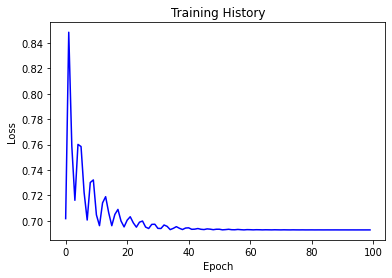

In [483]:
plt.figure(figsize=(6,4))
plt.plot(history['training_loss'],c='b',label='Train Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')

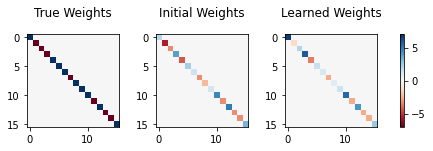

In [484]:
new_ham_matrix = create_hamiltonian_matrix(qubit_number, nx.complete_graph(qubit_number), new_weights, new_bias)
init_ham = create_hamiltonian_matrix(qubit_number, nx.complete_graph(qubit_number), initial_weights, initial_bias)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 1.7))

axes[0].imshow(ham_matrix, vmin=-7, vmax=7, cmap="RdBu")
axes[0].set_title("True Weights", y=1.13)

axes[1].imshow(init_ham, vmin=-7, vmax=7, cmap="RdBu")
axes[1].set_title("Initial Weights", y=1.13)

im=axes[2].imshow(new_ham_matrix, vmin=-7, vmax=7, cmap="RdBu")
axes[2].set_title("Learned Weights", y=1.13)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.colorbar(im,ax=axes.ravel().tolist())
plt.show()

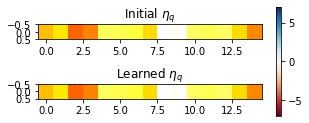

In [485]:
fig,axes = plt.subplots(2,1,figsize=(5,2))

plt.subplot(2,1,1)
plt.imshow(initial_eta.reshape(1,N),vmin=-np.max(eta),vmax=np.max(eta),cmap='hot')
plt.title(r'Initial $\eta_q$')

plt.subplot(2,1,2)
plt.imshow(eta.reshape(1,N),vmin=-np.max(eta),vmax=np.max(eta),cmap='hot')
plt.title(r'Learned $\eta_q$')

plt.colorbar(im,ax=axes.ravel().tolist())
plt.show()

In [486]:
target_weights

[-102.12159080365596, 100, 100, 100, 100, -72.37952419995615]

In [487]:
new_weights

tensor([ 0.80810715, -0.24951163, -0.38079565, -0.26663344,  0.72385307,
         0.37227075], requires_grad=True)

In [488]:
new_bias

tensor([0.03329371, 0.05233243, 0.1977383 , 0.36001446], requires_grad=True)

In [489]:
new_bias1

tensor([ 0.31585355, -0.4972615 ,  0.35740428, -0.46641442], requires_grad=True)

In [490]:
new_bias2

tensor([ 0.22965545, -0.32434438,  0.36317892,  0.04146122], requires_grad=True)

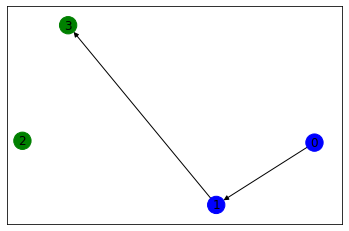

In [491]:
# draw learned graph
number_of_edges_desired = int(2*M*(M-1)/2)
indices_of_edges = np.argsort(np.abs(new_weights))[-number_of_edges_desired:]
final_edges_selected = [make_jet_edges[indx] for indx in indices_of_edges]
learned_ising_graph = nx.DiGraph()
learned_ising_graph.add_nodes_from(pos)
learned_ising_graph.add_edges_from(final_edges_selected) 
nx.draw_networkx(learned_ising_graph, pos, node_color=color_map, edgelist=final_edges_selected)

## Quantum Graph Recurrent Neural Network - Second Demonstration

Here, we will predict the direction of attachments of a graph via a QGRNN. For the QGRNN, we can write the Hamiltonian for this graph problem as 
$$H(\theta,\beta) = \sum_{(i,j)\in\mathcal{E}} \theta_{ij} \sigma_i^z \sigma_j^z + \sum_{i=1}^{qubits} \beta_i \sigma_i^z+ \sum_{i=1}^{qubits}  \sigma_i^x$$
where 
$$\mathbb{U}_H(\theta,\beta,\gamma) = \prod_{p=1}^p \left[ \prod_{q=1}^q e^{-i \gamma_q} H_q(\theta,\beta) \right]$$
where we send $\gamma_q \to t_p$, i.e. simple time stamps. We can evolve a close-to-ground state $|\psi_0\rangle$ of a known $H$ to obtain time evolved states $|\psi_p(t)\rangle$. We can then train the layers with a newly parametrized guess for the new interaction graph to act on $|\psi_0\rangle$ in order to match known $|\psi_p(t)\rangle$. In other words, we minimize
$$\mathcal{L}(\theta,\beta) = 1 - \frac{1}{N} \sum_{i=1}^N | \langle \psi_p(t)| \mathbb{U}_H(\theta,\beta,t_p) |\psi_0 \rangle |^2$$

[2] https://pennylane.ai/qml/demos/tutorial_qgrnn.html

In [507]:
rng = np.random.default_rng(seed=42)

In [508]:
def create_hamiltonian_matrix(n_qubits, graph, weights, bias):

    full_matrix = np.zeros((2 ** n_qubits, 2 ** n_qubits))

    # Creates the interaction component of the Hamiltonian
    for i, edge in enumerate(graph.edges):
        interaction_term = 1
        for qubit in range(0, n_qubits):
            if qubit in edge:
                interaction_term = np.kron(interaction_term, qml.matrix(qml.PauliZ)(0))
            else:
                interaction_term = np.kron(interaction_term, np.identity(2))
        full_matrix += weights[i] * interaction_term

    # Creates the bias components of the matrix
    for i in range(0, n_qubits):
        z_term = x_term = 1
        for j in range(0, n_qubits):
            if j == i:
                z_term = np.kron(z_term, qml.matrix(qml.PauliZ)(0))
                x_term = np.kron(x_term, qml.matrix(qml.PauliX)(0))
            else:
                z_term = np.kron(z_term, np.identity(2))
                x_term = np.kron(x_term, np.identity(2))
        full_matrix += bias[i] * z_term + x_term

    return full_matrix

In [509]:
def state_evolve(hamiltonian, qubits, time):
    U = scipy.linalg.expm(-1j * hamiltonian * time)
    qml.QubitUnitary(U, wires=qubits)

In [510]:
def qgrnn_layer(weights, bias, qubits, graph, trotter_step):
    # Applies a layer of RZZ gates (based on a graph)
    for i, edge in enumerate(graph.edges):
        qml.MultiRZ(2 * weights[i] * trotter_step, wires=(edge[0], edge[1]))
    # Applies a layer of RZ gates
    for i, qubit in enumerate(qubits):
        qml.RZ(2 * bias[i] * trotter_step, wires=qubit)
    # Applies a layer of RX gates
    for qubit in qubits:
        qml.RX(2 * trotter_step, wires=qubit)

In [511]:
def qgrnn(weights, bias, time=None):
    # Prepares the low energy state in the two registers
    qml.QubitStateVector(np.kron(low_energy_state, low_energy_state), wires=reg1 + reg2)
    # Evolves the first qubit register with the time-evolution circuit to
    # prepare a piece of quantum data
    state_evolve(ham_matrix, reg1, time)
    # Applies the QGRNN layers to the second qubit register
    depth = time / trotter_step  # P = t/Delta
    for _ in range(0, int(depth)):
        qgrnn_layer(weights, bias, reg2, new_ising_graph, trotter_step)
    # Applies the SWAP test between the registers
    swap_test(control, reg1, reg2)
    # Returns the results of the SWAP test
    return qml.expval(qml.PauliZ(control))

In [512]:
def cost_function(weight_params, bias_params):
    # Randomly samples times at which the QGRNN runs
    times_sampled = rng.random(size=N) * max_time
    # samples times and calculates the cost
    total_cost = 0
    for dt in times_sampled:
        result = qgrnn_qnode(weight_params, bias_params, time=dt)
        total_cost += -1 * result
    return total_cost / N

In [513]:
qubit_number = 4
qubits = range(qubit_number)

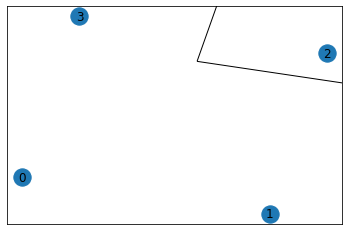

In [514]:
ising_graph = nx.cycle_graph(qubit_number)
nx.draw_networkx(ising_graph)

In [515]:
# Prepare hamiltonian weights
target_weights = np.random.uniform(low=-3,high=3,size=len(ising_graph.edges)) 
target_bias = np.random.uniform(low=-3,high=3,size=2**qubit_number)
# Prepare initial low energy state
low_energy_state_tensor = np.random.normal(loc=0.0, scale=0.01, size=2**qubit_number)*1 + 1j*np.random.normal(loc=0.0, scale=0.01, size=2**qubit_number)
normalize_factor = np.sqrt(np.abs(np.conj(low_energy_state_tensor)@low_energy_state_tensor))
low_energy_state_tensor =low_energy_state_tensor /normalize_factor
low_energy_state =[ (low_energy_state_tensor[i].item()) for i in range(low_energy_state_tensor.shape[0])]

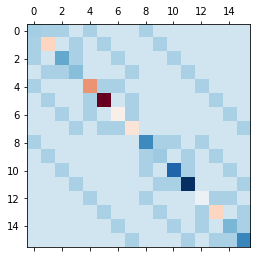

In [516]:
ham_matrix = create_hamiltonian_matrix(qubit_number, ising_graph, target_weights, target_bias)
plt.matshow(ham_matrix, cmap="RdBu")
plt.show()

In [517]:
res = np.vdot(low_energy_state, (ham_matrix @ low_energy_state))
energy_exp = np.real_if_close(res)
print(f"Energy Expectation: {energy_exp}")
ground_state_energy = np.real_if_close(min(np.linalg.eig(ham_matrix)[0]))
print(f"Ground State Energy: {ground_state_energy}")

Energy Expectation: 0.19605837656444086
Ground State Energy: -10.053762184319803


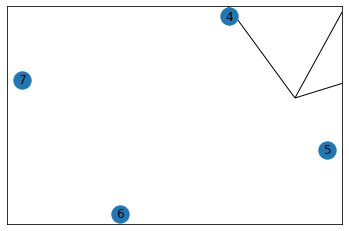

In [518]:
# make a new graph to be mapped to the original one to determine the necessary interactions between qubits
reg1 = tuple(range(qubit_number))  # state 1
reg2 = tuple(range(qubit_number, 2 * qubit_number))  # state 2
control = 2 * qubit_number  # Index of control qubit
trotter_step = 0.01  # Trotter step size
N = 15  # The number of pieces of quantum data that are used for each step
max_time = 0.1  # The maximum value of time that can be used for quantum data
# Defines the interaction graph for the new qubit system
new_ising_graph = nx.complete_graph(reg2)
nx.draw_networkx(new_ising_graph)

In [519]:
# Defines the new device
qgrnn_dev = qml.device("default.qubit", wires=2 * qubit_number + 1)
# Defines the new QNode
qgrnn_qnode = qml.QNode(qgrnn, qgrnn_dev, interface="autograd",diff_method='backprop')
steps = 300
optimizer = qml.AdamOptimizer(stepsize=0.5)
weights = rng.random(size=len(new_ising_graph.edges), requires_grad=True) - 0.5
bias = rng.random(size=qubit_number, requires_grad=True) - 0.5
initial_weights = copy.copy(weights)
initial_bias = copy.copy(bias)

In [521]:
print(qml.draw(qgrnn)(target_weights, target_bias,time=0.01))

0: ─╭QubitStateVector(M0)─╭U(M1)────────────────────────────────────────────────────────────────────
1: ─├QubitStateVector(M0)─├U(M1)────────────────────────────────────────────────────────────────────
2: ─├QubitStateVector(M0)─├U(M1)────────────────────────────────────────────────────────────────────
3: ─├QubitStateVector(M0)─╰U(M1)────────────────────────────────────────────────────────────────────
4: ─├QubitStateVector(M0)─╭MultiRZ(0.01)─╭MultiRZ(0.01)─╭MultiRZ(0.01)──RZ(-0.04)──────RX(0.02)─────
5: ─├QubitStateVector(M0)─╰MultiRZ(0.01)─│──────────────│──────────────╭MultiRZ(0.02)─╭MultiRZ(0.02)
6: ─├QubitStateVector(M0)────────────────╰MultiRZ(0.01)─│──────────────╰MultiRZ(0.02)─│─────────────
7: ─╰QubitStateVector(M0)───────────────────────────────╰MultiRZ(0.01)────────────────╰MultiRZ(0.02)
8: ──H──────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────────────────╭SWAP──────────────────────┤     
─────────────────

In [522]:
# train
print('---------------------------------Training---------------------------------')
start_time = time()
for i in range(0, steps):
    (weights, bias), loss = optimizer.step_and_cost(cost_function, weights, bias)
    if i%10==0:
        if i==0:
            print(' Step: {}  |'.format(i)+
                  ' Training Loss: {:.4f} |'.format(loss))
        else:
            print(' Step: {} |'.format(i)+
                  ' Training Loss: {:.4f} |'.format(loss))
end_time = time()
print('Training Complete. Total Time: {}'.format(end_time-start_time))

---------------------------------Training---------------------------------
 Step: 0  | Training Loss: -0.9353 |
 Step: 10 | Training Loss: -0.9917 |
 Step: 20 | Training Loss: -0.9966 |
 Step: 30 | Training Loss: -0.9990 |
 Step: 40 | Training Loss: -0.9993 |
 Step: 50 | Training Loss: -0.9996 |
 Step: 60 | Training Loss: -0.9996 |
 Step: 70 | Training Loss: -0.9997 |
 Step: 80 | Training Loss: -0.9997 |
 Step: 90 | Training Loss: -0.9995 |
 Step: 100 | Training Loss: -0.9995 |
 Step: 110 | Training Loss: -0.9998 |
 Step: 120 | Training Loss: -0.9997 |
 Step: 130 | Training Loss: -0.9997 |
 Step: 140 | Training Loss: -0.9996 |
 Step: 150 | Training Loss: -0.9997 |
 Step: 160 | Training Loss: -0.9995 |
 Step: 170 | Training Loss: -0.9996 |
 Step: 180 | Training Loss: -0.9998 |
 Step: 190 | Training Loss: -0.9999 |
 Step: 200 | Training Loss: -0.9995 |
 Step: 210 | Training Loss: -0.9994 |
 Step: 220 | Training Loss: -0.9996 |
 Step: 230 | Training Loss: -0.9998 |
 Step: 240 | Training L

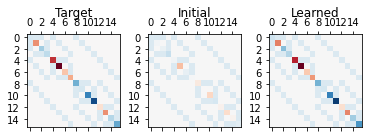

In [525]:
new_ham_matrix = create_hamiltonian_matrix(qubit_number, nx.complete_graph(qubit_number), weights, bias)
init_ham = create_hamiltonian_matrix(qubit_number, nx.complete_graph(qubit_number), initial_weights, initial_bias)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 6))

axes[0].matshow(ham_matrix, vmin=-7, vmax=7, cmap="RdBu")
axes[0].set_title("Target", y=1.13)

axes[1].matshow(init_ham, vmin=-7, vmax=7, cmap="RdBu")
axes[1].set_title("Initial", y=1.13)

axes[2].matshow(new_ham_matrix, vmin=-7, vmax=7, cmap="RdBu")
axes[2].set_title("Learned", y=1.13)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [524]:
# pick out the weights of edges (1, 3) and (2, 0)
# and then remove them from the list of target parameters
weights_noedge = []
weights_edge = []
for ind, edge in enumerate(new_ising_graph.edges):
    if (edge[0] - qubit_number, edge[1] - qubit_number) in ising_graph.edges:
        weights_edge.append(weights[ind])
    else:
        weights_noedge.append(weights[ind])
print("Target parameters     Learned parameters")
print("Weights")
print("-" * 41)
for targetw, learnedw in zip(target_weights, weights_edge):
    print(f"{targetw : <20}|{learnedw : >20}")

print("\nBias")
print("-"*41)
for targetw, learnedw in zip(target_bias, bias):
    print(f"{targetw : <20}|{learnedw : >20}")

print(f"\nNon-Existing Edge Parameters: {[val.unwrap() for val in weights_noedge]}")

Target parameters     Learned parameters
Weights
-----------------------------------------
0.41978946420758945 |  0.6175021991733822
0.5452365674890394  |   0.720466680806094
0.44595149309747306 |  0.5112906317703664
0.9192049191428016  |  0.9914033536990465

Bias
-----------------------------------------
-2.1033101720520375 | -2.2415052009614245
2.2087563442092852  |  2.3617815251526175
-2.025042391941751  | -2.2629181570938686
0.6933573857030648  |  0.8177654480415384

Non-Existing Edge Parameters: [-0.026240866987160487, -0.06492570533093109]


It learns the parametrisized Hamiltonian well, as shown from the plot above, and since since (1,3) and (2,0) have weights which are very small (close to 0), this shows we have learned the connected graph structure from the beginning. The network seems to work well and finds the desired weights of the Ising Hamiltonian.

---

## Task VII: Equivariant quantum neural networks

In this task you are supposed to get started with equivariant quantum neural networks by implementing a Z_2 × Z_2 equivariant quantum neural network. Z_2 is a symmetry group an as an example we will generate a simple classical dataset which is respects the Z_2 x Z_2 symmetry.
This example is explained in the paper 

- https://arxiv.org/abs/2205.06217 

and additional background can be found in 

- https://arxiv.org/abs/2210.08566. 


Generate a classification dataset with two classes and two features x_1 and x_2 which respects the Z_2 x Z_2 symmetry (this corresponds to mirroring along y=x). An example can be found in the first reference paper.


Train a QNN to solve the classification problem


Train an Z_2 x Z_2 equivariant QNN to solve the classification problem and compare the results.

- [1] https://pennylane.ai/qml/demos/tutorial_variational_classifier.html
- [2] https://arxiv.org/abs/quant-ph/0407010
- [3] https://link.springer.com/book/10.1007/978-3-319-96424-9
- [4] https://michaelnielsen.org/qcqi/
- [5] https://journals.aps.org/prd/pdf/10.1103/PhysRevD.105.096031 (symmetry group data descriptions)

Created an equivariant dataset by forming random squares in the positive quadrant, and then proceeded to label a non-trivial expected $\mathbb{Z}_2 \times \mathbb{Z}_2$ symmetric classes.

In [526]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.optimize import GradientDescentOptimizer
import matplotlib.pyplot as plt

In [566]:
np.random.seed(0)
dsize = 20
s=0.01
l=0.9
s1=1.1
l1=2
square2 = np.random.uniform(s, l, dsize) + 1.j * np.random.uniform(s, l, dsize)
square1 = np.random.uniform(s1, l1, dsize) + 1.j * np.random.uniform(s, l, dsize)
square3 = np.random.uniform(s, l, dsize) + 1.j * np.random.uniform(s1, l1, dsize)
square4 = np.random.uniform(s1, l1, dsize) + 1.j * np.random.uniform(s1, l1, dsize)
squares = [square2,square4,square1,square3]
coordinates = np.zeros((dsize*len(squares),2))
labels = np.zeros(((dsize*len(squares),1)))
for i,square in enumerate(squares):
    for j,point in enumerate(square):
        coordinates[i*dsize+j,:] = np.array([point.real,point.imag])
        if i==0:
                labels[i*dsize+j] = np.array([-1])
        elif i==1:
                labels[i*dsize+j] = np.array([1])
        elif i==2:
            if np.abs(point.real-1)<=1-np.abs(point.imag):
                labels[i*dsize+j] = np.array([1])
            else:
                labels[i*dsize+j] = np.array([-1])
        elif i==3:
            if np.abs(point.real)>=1-np.abs(point.imag-1):
                labels[i*dsize+j] = np.array([-1])
            else:
                labels[i*dsize+j] = np.array([1])
            
reflect = np.array([[0 ,1],
                    [1,0]]).reshape(2,2)
add_coordinates = np.transpose(reflect@np.transpose(coordinates))
add_labels = copy.copy(labels)
coordinates = np.vstack([coordinates,add_coordinates])
labels = np.vstack([labels,add_labels])

Text(0.5, 1.0, 'Data with Labels')

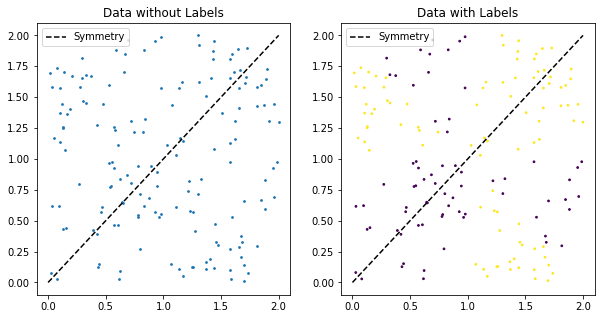

In [567]:
plt.subplots(1,2,figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,2,100),np.linspace(0,2,100),linestyle='--',c='black',label='Symmetry')
plt.scatter(coordinates[:,0],coordinates[:,1],s=3)
plt.legend()
plt.title('Data without Labels')
plt.subplot(1,2,2)
plt.plot(np.linspace(0,2,100),np.linspace(0,2,100),linestyle='--',c='black',label='Symmetry')
plt.scatter(coordinates[:,0],coordinates[:,1],c=labels,s=3)
plt.legend()
plt.title('Data with Labels')

In [568]:
num_qubits = 2
vqnn_dev = qml.device("default.qubit", wires=num_qubits)
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.sqrt(x[2] ** 2 + x[3] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2))
    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

def statepreparation(a):
    qml.RY(a[0], wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)
    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])
    
@qml.qnode(vqnn_dev, interface="autograd")
def vqnn_model(weights, angles):
    statepreparation(angles)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))#.numeric_type()

def vqnn(weights, bias, angles):
    return vqnn_model(weights, angles) + bias

def cost(weights, bias, features, labels):
    predictions = [vqnn(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss += (l - p) ** 2
    loss = loss / labels.shape[0]
    return loss
    
def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-3:
            loss += 1
    loss = loss / labels.shape[0]
    return loss

In [569]:
X = copy.copy(coordinates)
print("First X sample (original)  :", X[0])
# pad the vectors to size 2^2 with constant values
padding = 0.5 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded)    :", X_pad[0])
# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, axis =-1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])
# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print("First features sample      :", features[0])
# normalization = np.sqrt(np.sum(X ** 2, axis =-1))
# features = (X.T / normalization).T
Y = copy.copy(labels)

First X sample (original)  : [0.55332537 0.97883216]
First X sample (padded)    : [0.55332537 0.97883216 0.5        0.        ]
First X sample (normalized): [0.44965279 0.79543545 0.40631861 0.        ]
First features sample      : [ 0.83684295 -0.          0.         -1.05628895  1.05628895]


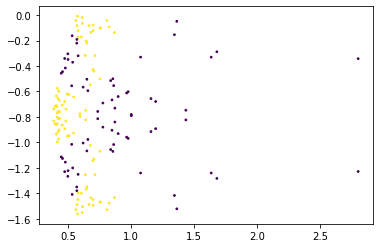

In [570]:
plt.scatter(features[:,0],features[:,3],c=Y,s=3)

In [601]:
np.random.seed(0)
num_data = Y.shape[0]
num_train = int(0.8 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [602]:
# Defines the new QNode
#vqnn_qnode = qml.QNode(vqnn_model, device=vqnn_dev, interface = 'autograd',diff_method='backprop')
num_layers = 8
optimizer = qml.GradientDescentOptimizer(stepsize=1e-2)#, beta1=0.5, beta2=0.999)
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)
weights = copy.copy(weights_init)
bias = copy.copy(bias_init)
batch_size=5#feats_train.shape[0]
steps=100
for it in range(steps):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = optimizer.step(cost, weights, bias, feats_train_batch, Y_train_batch)
    # Compute predictions on train and validation set
    predictions_train = [np.sign(vqnn(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(vqnn(weights, bias, f)) for f in feats_val]
    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    if it%10==0:
        print("Iter: {} | Cost: {:.4f} | Acc train: {:.4f} | Acc validation: {:.4f} ".format(it, qml.math.toarray(cost(weights, bias, features, Y))[0], acc_train, acc_val) )

Iter: 0 | Cost: 1.1567 | Acc train: 0.5625 | Acc validation: 0.7500 
Iter: 10 | Cost: 0.8285 | Acc train: 0.6250 | Acc validation: 0.8125 
Iter: 20 | Cost: 0.7757 | Acc train: 0.7812 | Acc validation: 0.9375 
Iter: 30 | Cost: 0.7770 | Acc train: 0.7578 | Acc validation: 0.9375 
Iter: 40 | Cost: 0.8330 | Acc train: 0.6328 | Acc validation: 0.6250 
Iter: 50 | Cost: 0.8716 | Acc train: 0.5156 | Acc validation: 0.4062 
Iter: 60 | Cost: 0.8081 | Acc train: 0.6797 | Acc validation: 0.8125 
Iter: 70 | Cost: 0.7832 | Acc train: 0.7031 | Acc validation: 0.8438 
Iter: 80 | Cost: 0.7759 | Acc train: 0.7500 | Acc validation: 0.8750 
Iter: 90 | Cost: 0.8203 | Acc train: 0.6641 | Acc validation: 0.6875 


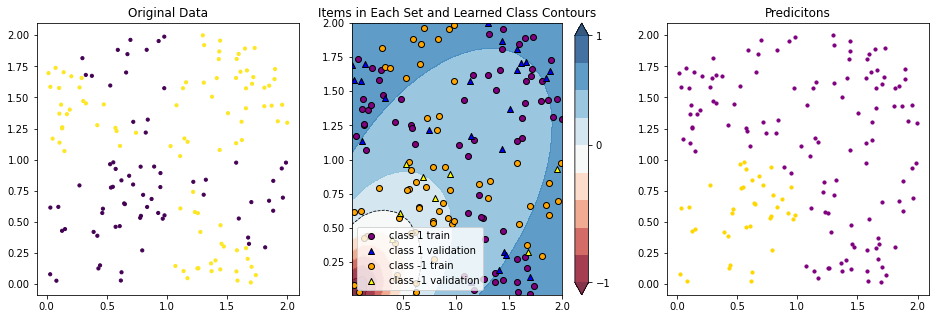

In [603]:
# plot data
plt.subplots(1,3,figsize=(16,5))
plt.subplot(1,3,1)
plt.scatter(coordinates[:,0],coordinates[:,1],c=labels,s=10)
plt.title('Original Data')
plt.subplot(1,3,2)

cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(s, l1, 20), np.linspace(s, l1, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles for state preparation are new features
predictions_grid = [vqnn(weights, bias, f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1, 0.2), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

plt.scatter(
    X_train[(Y_train == 1).reshape(Y_train.shape[0],),0],
    X_train[(Y_train == 1).reshape(Y_train.shape[0],),1],
    c="purple",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[(Y_val == 1).reshape(Y_val.shape[0],),0],
    X_val[(Y_val == 1).reshape(Y_val.shape[0],),1],
    c="blue",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[(Y_train == -1).reshape(Y_train.shape[0],),0],
    X_train[(Y_train == -1).reshape(Y_train.shape[0],),1],
    c="orange",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[(Y_val == -1).reshape(Y_val.shape[0],),0],
    X_val[(Y_val == -1).reshape(Y_val.shape[0],),1],
    c="yellow",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)
plt.title('Items in Each Set and Learned Class Contours')

plt.legend()

plt.subplot(1,3,3)
predictions_now = [int(np.sign(vqnn(weights, bias, f)).item()) for f in features]
for i in range(len(predictions_now)):
    if predictions_now[i]==-1:
        plt.scatter(X[i,0].item(),X[i,1].item(),c='gold',s=10)
    else:
        plt.scatter(X[i,0].item(),X[i,1].item(),c='purple',s=10)
plt.title('Predicitons')
plt.show()

## Equivariant Quantum Neural Network

Based on the equivriance condition:
$$\mathcal{L} = |f(Mx) -  M'f(|\psi\rangle)|^2$$
In particular,
$$\mathcal{L} = |f(\mathcal{R}X) -  \sigma_xf(|\psi\rangle)|^2$$
where $\mathcal{R} =\begin{pmatrix} 0 &-1 \\ -1&0 \end{pmatrix}$ acting in the original data space, and $\sigma_x$ is the pauli matrix flipping the final state before measurement. Note, we reflect across $y=-x$, the antisymmetric axis of $\mathbb{Z}_2 \times \mathbb{Z}_2$ because this is associated with a change of sign in the final expectation value of the z-Pauli operator, otherwise we would be checking invariance. We can add four more qubits to run through the mnodel, two for the first valued function where we transform the data before forming the initial state, and two for the second valued state which gets affected after being processed by the model by the x-Pauli operator to flip its respective state.

In [604]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.sqrt(x[2] ** 2 + x[3] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2))
    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

def statepreparation_equi(a,wire1,wire2):
    qml.RY(a[0], wires=wire1)
    qml.CNOT(wires=[wire1, wire2])
    qml.RY(a[1], wires=wire2)
    qml.CNOT(wires=[wire1,wire2])
    qml.RY(a[2], wires=wire2)
    qml.PauliX(wires=wire1)
    qml.CNOT(wires=[wire1,wire2])
    qml.RY(a[3], wires=wire2)
    qml.CNOT(wires=[wire1,wire2])
    qml.RY(a[4], wires=wire2)
    qml.PauliX(wires=wire1)

def layer_equi(W,wire1,wire2):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=wire1)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=wire2)
    qml.CNOT(wires=[wire1, wire2])
    
def vqnn_model_equi(weights, angles, new_angles):
    wire1=0; wire2=1
    statepreparation_equi(angles,wire1=wire1,wire2=wire2)
    for W in weights:
        layer_equi(W,wire1,wire2)
        
    #Equi Apply at Beginning and reads in transformed state vector
    wire1=2; wire2=3
    statepreparation_equi(new_angles,wire1=wire1,wire2=wire2)
    for W in weights:
        layer_equi(W,wire1,wire2)
    #Equi Apply at End and flips the final state before measurement
    wire1=4; wire2=5
    statepreparation_equi(angles,wire1=wire1,wire2=wire2)
    for W in weights:
        layer_equi(W,wire1,wire2)
    qml.PauliX(wires=wire1)
    
    
    return [qml.expval(qml.PauliZ(wires=i)).numeric_type() for i in range(0,6,2)]

def vqnn_equi(weights, bias, angles, new_angles):
    values_stored = vqnn_model_equi(weights, angles, new_angles)
    return [values_stored[0] + bias, values_stored[1]+bias, values_stored[2]+bias]

def cost_equi(weights, bias, features, labels, new_features):
    predictions = []
    equi_terms1 = []
    equi_terms2 = []
    for f,f_new in zip(features,new_features):
        values_stored = vqnn_equi(weights, bias, f, f_new)
        predictions.append(values_stored[0])
        equi_terms1.append(values_stored[1])
        equi_terms2.append(values_stored[2])
    return square_loss(labels, predictions)+ square_loss(equi_terms1,equi_terms2)

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss += (l - p) ** 2
    loss = loss / len(labels)
    return loss
    
def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-3:
            loss += 1
    loss = loss / labels.shape[0]
    return loss

In [605]:
reflect_new = np.array([[0 ,-1],
                        [-1,0]]).reshape(2,2)
coordinates_new = np.transpose(reflect_new@np.transpose(coordinates))+2.0
labels_new = copy.copy(-1*labels)

X_new = copy.copy(coordinates_new)
print("New First X sample (original)  :", X[0])
# pad the vectors to size 2^2 with constant values
padding = 0.5 * np.ones((len(X), 1))
X_pad_new = np.c_[np.c_[X_new, padding], np.zeros((len(X_new), 1))]
print("New First X sample (padded)    :", X_pad_new[0])
# normalize each input
normalization_new = np.sqrt(np.sum(X_pad_new ** 2, axis =-1))
X_norm_new = (X_pad_new.T / normalization_new).T
print("New First X sample (normalized):", X_norm[0])
# angles for state preparation are new features
features_new = np.array([get_angles(x) for x in X_norm_new], requires_grad=False)
print("New First features sample      :", features_new[0])
# normalization = np.sqrt(np.sum(X ** 2, axis =-1))
# features = (X.T / normalization).T
Y_new = copy.copy(labels_new)

New First X sample (original)  : [0.55332537 0.97883216]
New First X sample (padded)    : [1.02116784 1.44667463 0.5        0.        ]
New First X sample (normalized): [0.44965279 0.79543545 0.40631861 0.        ]
New First features sample      : [ 0.55039513 -0.          0.         -0.95613995  0.95613995]


Text(0.5, 1.0, 'Old Data and New Data for Equivariance Constraint')

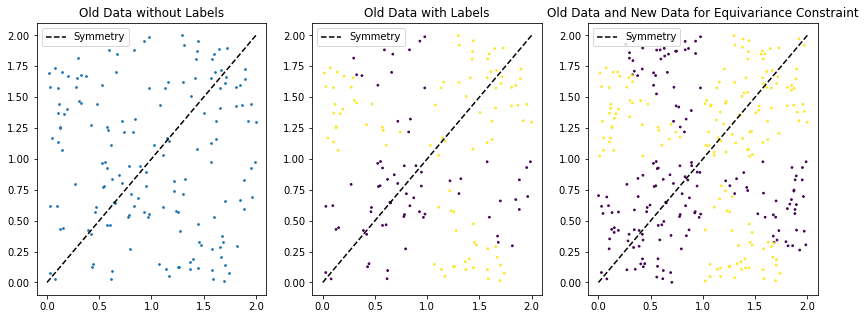

In [606]:
plt.subplots(1,3,figsize=(14,5))
plt.subplot(1,3,1)
plt.plot(np.linspace(0,2,100),np.linspace(0,2,100),linestyle='--',c='black',label='Symmetry')
plt.scatter(X[:,0],X[:,1],s=3)
plt.legend()
plt.title('Old Data without Labels')
plt.subplot(1,3,2)
plt.plot(np.linspace(0,2,100),np.linspace(0,2,100),linestyle='--',c='black',label='Symmetry')
plt.scatter(X[:,0],X[:,1],c=Y,s=3)
plt.legend()
plt.title('Old Data with Labels')
plt.subplot(1,3,3)
plt.plot(np.linspace(0,2,100),np.linspace(0,2,100),linestyle='--',c='black',label='Symmetry')
plt.scatter(X[:,0],X[:,1],c=Y,s=3)
plt.scatter(X_new[:,0],X_new[:,1],c=Y_new,s=3)
plt.legend()
plt.title('Old Data and New Data for Equivariance Constraint')

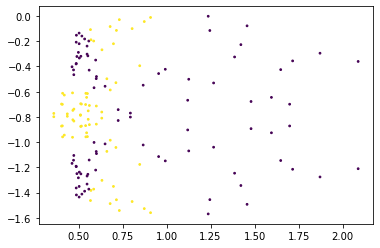

In [607]:
plt.scatter(features_new[:,0],features_new[:,3],c=Y_new,s=3)

In [608]:
feats_train_new = features_new[index[:num_train]]

In [612]:
# Defines the new QNode
num_qubits = 2
vqnn_dev_equi = qml.device("default.qubit", wires=num_qubits*3)
vqnn_qnode = qml.QNode(vqnn_model_equi, device=vqnn_dev_equi, interface = 'autograd',diff_method='backprop')
num_layers = 10
optimizer = qml.GradientDescentOptimizer(stepsize=1e-3)#, beta1=0.5, beta2=0.999)
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)
weights = copy.copy(weights_init)
bias = copy.copy(bias_init)
batch_size=5
steps=100
for it in range(steps):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    feats_train_new_batch= feats_train_new[batch_index]
    weights, bias, _, _, _ = optimizer.step(cost_equi, weights, bias, feats_train_batch, Y_train_batch, feats_train_new_batch)
    # Compute predictions on train and validation set
    predictions_train = [np.sign(vqnn_equi(weights, bias, f, f))[0] for f in feats_train]
    predictions_val = [np.sign(vqnn_equi(weights, bias, f, f))[0] for f in feats_val]
    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    if it%10==0:
        print("Iter: {} | Cost: {:.4f} | Acc train: {:.4f} | Acc validation: {:.4f} ".format(it, qml.math.toarray(cost_equi(weights, bias, features, Y, features_new))[0], acc_train, acc_val) )

Iter: 0 | Cost: 0.9997 | Acc train: 0.5156 | Acc validation: 0.7500 
Iter: 10 | Cost: 0.9986 | Acc train: 0.5156 | Acc validation: 0.7500 
Iter: 20 | Cost: 0.9977 | Acc train: 0.5156 | Acc validation: 0.7500 
Iter: 30 | Cost: 0.9983 | Acc train: 0.5156 | Acc validation: 0.7500 
Iter: 40 | Cost: 0.9985 | Acc train: 0.5156 | Acc validation: 0.7500 
Iter: 50 | Cost: 0.9993 | Acc train: 0.5156 | Acc validation: 0.7500 
Iter: 60 | Cost: 1.0001 | Acc train: 0.4844 | Acc validation: 0.2500 
Iter: 70 | Cost: 0.9987 | Acc train: 0.5156 | Acc validation: 0.7500 
Iter: 80 | Cost: 0.9978 | Acc train: 0.5156 | Acc validation: 0.7500 
Iter: 90 | Cost: 0.9980 | Acc train: 0.5156 | Acc validation: 0.7500 


<ipython-input-614-5fe8ae4376f7>:23: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))


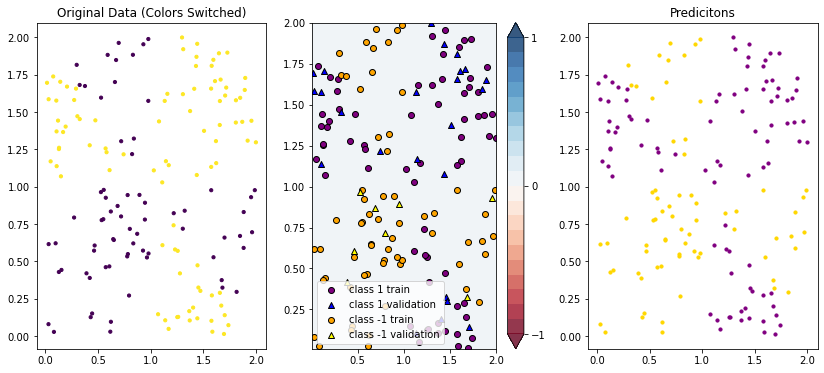

In [614]:
# plot data
plt.subplots(1,3,figsize=(14,6))
plt.subplot(1,3,1)
plt.scatter(coordinates[:,0],coordinates[:,1],c=labels,s=10)
plt.title('Original Data (Colors Switched)')
plt.subplot(1,3,2)

cm = plt.cm.RdBu
# make data for decision regions
xx, yy = np.meshgrid(np.linspace(s, l1, 20), np.linspace(s, l1, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles for state preparation are new features
predictions_grid = [vqnn_equi(weights, bias, f,f)[0] for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

plt.scatter(
    X_train[(Y_train == 1).reshape(Y_train.shape[0],),0],
    X_train[(Y_train == 1).reshape(Y_train.shape[0],),1],
    c="purple",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[(Y_val == 1).reshape(Y_val.shape[0],),0],
    X_val[(Y_val == 1).reshape(Y_val.shape[0],),1],
    c="blue",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[(Y_train == -1).reshape(Y_train.shape[0],),0],
    X_train[(Y_train == -1).reshape(Y_train.shape[0],),1],
    c="orange",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[(Y_val == -1).reshape(Y_val.shape[0],),0],
    X_val[(Y_val == -1).reshape(Y_val.shape[0],),1],
    c="yellow",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)
plt.legend()

plt.subplot(1,3,3)
predictions_new = [int(np.sign(vqnn_equi(weights, bias, f,f)[0]).item()) for f in features]
for i in range(len(Y)):
    if Y[i].item()==-1:
        plt.scatter(X[i,0].item(),X[i,1].item(),c='gold',s=10)
    else:
        plt.scatter(X[i,0].item(),X[i,1].item(),c='purple',s=10)
plt.title('Predicitons')
plt.show()

---

## Task VIII: Vision transformer/Quantum Vision Transformer


Implement a classical Vision transformer and apply it to MNIST. Show its performance on the test data. Comment on potential ideas to extend this classical vision transformer architecture to a quantum vision transformer and sketch out the architecture in detail.

[1] Adaptation from https://github.com/daewoung/Vision-Transformer-MNIST-Pytorch-Lightning/blob/main/VIT_MNIST_LI.ipynb

In [615]:
import numpy as np
import os
import torch
from torch import nn
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
from einops.layers.torch import Reduce
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torchmetrics
torch.manual_seed(0)
torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [616]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor()
)

n1 = int(55e3)
n2 = int(5e3)
train_dataset, val_dataset = random_split(training_data, [n1, n2])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size,num_workers=2)
data, label = next(iter(train_dataloader))
data = data.to(device)
label = label.to(device)
print('Data Shape: ',data.shape)
print('Labels Shape: ',label.shape)

Data Shape:  torch.Size([5, 1, 28, 28])
Labels Shape:  torch.Size([5])


In [617]:
class EmbeddingLayer(nn.Module):
    def __init__(self,in_chan, img_size, patch_size,batch_size=128):
        super().__init__()
        self.num_patches = int(img_size / np.power(patch_size,2) ) # 49
        self.emb_size = int(in_chan * patch_size * patch_size) # 16
        self.project = nn.Conv2d(in_chan, self.emb_size, kernel_size= patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1,1,self.emb_size))
        self.positions = nn.Parameter(torch.randn(self.num_patches+ 1, self.emb_size)) # [50,16]
    
    def forward(self, x):
        x = self.project(x)
        x = x.view(-1, 49, 16) # [batch_size, 49, 16]
        repeat_cls = self.cls_token.repeat(x.size()[0],1,1) #[batch_size, 1 , 16]
        x = torch.cat((repeat_cls, x), dim=1)
        x += self.positions
        return x

class Multihead(nn.Module):
    def __init__(self, emb_size, num_heads):
        super().__init__()
        self.multiheadattention = nn.MultiheadAttention(emb_size, num_heads, batch_first = True, dropout=0.2)
        self.query = nn.Linear(emb_size, emb_size)
        self.key = nn.Linear(emb_size, emb_size)
        self.value = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        attn_output, attention = self.multiheadattention(query, key, value)
        return attn_output, attention
    
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion = 4, p = 0.2):
        super().__init__(nn.Linear(emb_size, expansion * emb_size),
                         nn.GELU(),
                         nn.Dropout(p),
                         nn.Linear(expansion * emb_size, emb_size)  )
        
class VIT(nn.Module):
    def __init__(self,emb_size = 16):
        super().__init__()
        self.embedding = EmbeddingLayer(1, 28*28, 4)
        self.Multihead = Multihead(emb_size, 8)
        self.FFB = FeedForwardBlock(emb_size)
        self.norm = nn.LayerNorm(emb_size)
        
    def forward(self, x):
        x = self.embedding(x)
        norm_x = self.norm(x)
        multihead_output, attention = self.Multihead(norm_x)
        #residual Function
        output = multihead_output + x
        norm_output = self.norm(output)
        FFB = self.FFB(norm_output)
        final_out = FFB + output
        
        return final_out, attention

class TransformerEncoder(nn.Module):
    def __init__(self, n_layers=5 ):
        super().__init__()
        self.layers = nn.ModuleList([VIT() for _ in range(n_layers)])
        
    def forward(self, x):
        for layer in self.layers:
            final_out, attention = layer(x)
            
        return final_out

In [618]:
class VIT_Encoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.loss = []
        self.Encoder = nn.Sequential(TransformerEncoder(n_layers = 5) )#,Reduce('b n e -> b e', reduction='mean')
        self.final_layer = nn.Linear(16, 10)
        self.val_loss = []
        self.acc = []
        self.test_acc =[]
        
    def forward(self, x):
        x = self.Encoder(x.type(torch.float64))
        cls_token_final = x[:,0]
        cls_token_final = self.final_layer(cls_token_final)
        return cls_token_final
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits,y)
        self.loss.append(loss.item())
        return loss 
    
    def training_epoch_end(self, batch):
        mean_loss = sum(self.loss) / 430
        print(f'traing_loss :{mean_loss}')
        self.loss = []
        self.acc = []
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits,y)
        self.val_loss.append(loss.item())
        acc = accuracy(logits, y)
        self.acc.append(acc)
        return loss 
    
    def validation_epoch_end(self, batch):
        mean_loss = sum(self.val_loss) / 40
        mean_acc = sum(self.acc) / 40
        print(f'val loss :{mean_loss}, val_acc : {mean_acc}')

        self.val_loss = []
        self.acc = []
        self.log("val_loss", mean_loss)
        
    def test_dataloader(self):
        return test_dataloader
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = accuracy(logits, y)
        self.test_acc.append(acc)
        
    def test_epoch_end(self, batch):
        mean_acc = sum(self.test_acc)/ 79
        print(mean_acc)
            
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)    

In [622]:
learning_rate = 1e-3
batch_size = 128
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes = 10).to(device)
early_stop_callback = EarlyStopping(monitor='val_loss', mode ='min', patience=5)
model = VIT_Encoder()
batch_test = model.test_dataloader()
batch_test_data, batch_test_labels = next(iter(batch_test))
print('Batch Test Data Shape: ',batch_test_data.shape)
print('Batch Test Labels Shape: ',batch_test_labels.shape)
model = VIT_Encoder().to(device)

Batch Test Data Shape:  torch.Size([5, 1, 28, 28])
Batch Test Labels Shape:  torch.Size([5])


In [ ]:
epochs=10
# Train from pytorchlightning
trainer = pl.Trainer(max_epochs=epochs, callbacks=[early_stop_callback])#gpus
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/roythomasf/Work/UF/Research/2023_GSoC/quantum_GNNs/lightning_logs

  | Name        | Type       | Params
-------------------------------------------
0 | Encoder     | Sequential | 25.8 K
1 | final_layer | Linear     | 170   
-------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.104     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

val loss :0.12593769860778622, val_acc : 0.004999999888241291


Training: 0it [00:00, ?it/s]

In [ ]:
trainer.test()

## Possibility for Quantum Transformer

Classical Vision Transformer:
1. Data into Patches
2. Patches to vectors
3. Enhance Patches with class embeddings (same size as patches)
4. Add positional embedding
5. Use class embedding at end to fully connected layer
6. Output to transformer: P layers (start of one transformer layer)
7. Normalization over all patches
8. Attention mechanism (W connects all vectors, turn into attention matrix A, apply AV to all x ->y)
9. Add initial state vectors in residual layer and renormalize
10. Multi-layer perception and add residual (end of one tranformer layer)
11. Take class embedding and apply layer for classes.

Quantum Vision Transformer:
1. Amplitude encoding of data ($d$ qubits for each vector of size $d$ using RBS gates)
$$| x_i \rangle = \frac{1}{|x|}\sum_{i=1}^d x_i | e_i \rangle$$
i.e. 1 in $i$-th state location, 0 therwise. 
2. Load rows through a vector data loader using CNOTs on ith qubit.
$$| X \rangle = \frac{1}{|X|}\sum_{i=1}^n\sum_{i=1}^d X_{ij} | e_i \rangle| e_j \rangle$$
2. Transformer: P layers (start of quantum transformer)
3. Quantum Orthogonal Layers (e.g. cascadement of RBS gates across adjacent states) for parametrization of the circuit of $d$ qubits. 
4. Apply same trainable Attention transformation matrix $V$ to encoded state multiple times find attention coefficients through the expectation values of $\langle W \rangle$ where $W$ is a trainable matrix. Combine to form $AVx=y$.
$$|y_i \rangle = \sum_j A_{ij} |e_j \rangle | V x_j \rangle$$
5. Could go one step further using fully connected transformations $R_{ij}$, ${d \choose 2}=d(d-1)/2$ of them, for all possible two qubit combinations (imitating self MLP). Can also use a classical fully connected MLP for this by taking new vectors as the complex values of the encoded complex states (qubits).
11. For two classes, take expectation value with respect to $PauliZ$ of the $i$-th qubit of $i$-th state vector. For multiple classes, look at the qubit state in the $i$th location of the $i$th vector, plot a 2D encoded classes plot using the real (x) and imag (y) as position vectors. For multiple classes, you can also use a classical Linear layer on $y_i$ and apply a softmax to reduce to the solutions, as well.

Note: We can also build this up to connect the encoded vectors more, as in a classical transformer, by applying the $V$ layers across two registers of encoded data.